In [188]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import evofr as ef
from evofr.plotting import *

raw_seq = pd.read_csv("../../HHMI_poster/data/seq_counts_nextstrain_clades_usa.tsv.gz", sep="\t").rename(columns={"clade": "variant"})
raw_cases =  pd.read_csv("../../HHMI_poster/data/case_counts_usa.tsv.gz", sep="\t")

In [189]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils

In [190]:
date_end = "2022-09-01"
date_start = "2021-03-01"

raw_seq = raw_seq[raw_seq.date < date_end].copy()
raw_seq = raw_seq[raw_seq.date > date_start].copy()

raw_cases = raw_cases[raw_cases.date < date_end].copy()
raw_cases = raw_cases[raw_cases.date > date_start].copy() # Cases stop in 2022?

In [191]:
from relative_fitness_hsgp import RelativeFitnessHSGP, SquaredExponential, Matern
import numpyro.distributions as dist

hsgp_mat = Matern(
    L=500, 
    num_basis=50,
    rho = dist.HalfNormal(15),
    alpha = dist.HalfNormal(0.1),
    nu=5/2)
hsgp_sq = SquaredExponential(
    L=180, 
    num_basis=45,
    rho = dist.HalfNormal(15),
    alpha = dist.HalfNormal(1e-2))
fitness_model = RelativeFitnessHSGP(hsgp_mat) # Do I need to add intercepts?
inference_method = ef.InferNUTS(num_samples=500, num_warmup=1000)
inference_method = ef.InferMAP(iters=30_000, lr=4e-4)

In [192]:
raw_seq.variant.unique()

array(['19A', '19B', '20A', '20B', '20C', '20D', '20G', '20H', '20I',
       '20J', '21A', '21C', '21D', '21F', '21G', '21H', '21I', '21J',
       '21K', '21L', '22A', '22B', '22C', '22D', 'recombinant', '22E',
       '21B', '20E', '21E', '21M', '22F', '23A', '23B', '23D'],
      dtype=object)

In [348]:
locations = pd.unique(raw_seq["location"])
locations = ["Nevada", "Texas", "Tennessee", "Oregon", "Pennsylvania", "Wisconsin", "Minnesota", "Massachusetts", "California", "Florida", "Michigan", "Illinois", "Ohio", "New York", "Georgia", "Virginia", "Washington"]
data = {}
cases = {}
for loc in locations:
    data[loc] = ef.VariantFrequencies(raw_seq[raw_seq.location == loc].copy(), pivot="21K")
    cases[loc] = raw_cases[raw_cases.location == loc].copy()
data

{'Nevada': <evofr.data.variant_frequencies.VariantFrequencies at 0x30ec4e9d0>,
 'Texas': <evofr.data.variant_frequencies.VariantFrequencies at 0x3027c2550>,
 'Tennessee': <evofr.data.variant_frequencies.VariantFrequencies at 0x2ff43cd50>,
 'Oregon': <evofr.data.variant_frequencies.VariantFrequencies at 0x308a4f710>,
 'Pennsylvania': <evofr.data.variant_frequencies.VariantFrequencies at 0x2ba007890>,
 'Wisconsin': <evofr.data.variant_frequencies.VariantFrequencies at 0x30ec74f90>,
 'Minnesota': <evofr.data.variant_frequencies.VariantFrequencies at 0x307463b10>,
 'Massachusetts': <evofr.data.variant_frequencies.VariantFrequencies at 0x2b4b232d0>,
 'California': <evofr.data.variant_frequencies.VariantFrequencies at 0x30ebd3690>,
 'Florida': <evofr.data.variant_frequencies.VariantFrequencies at 0x30ebd2ad0>,
 'Michigan': <evofr.data.variant_frequencies.VariantFrequencies at 0x30e438210>,
 'Illinois': <evofr.data.variant_frequencies.VariantFrequencies at 0x30ebbba50>,
 'Ohio': <evofr.data.v

In [349]:
# Fit models
posteriors = {}
for loc in locations:
    posteriors[loc] = inference_method.fit(fitness_model, data=data[loc]) 
posteriors

{'Nevada': <evofr.posterior.posterior_handler.PosteriorHandler at 0x31c07e190>,
 'Texas': <evofr.posterior.posterior_handler.PosteriorHandler at 0x30eb42590>,
 'Tennessee': <evofr.posterior.posterior_handler.PosteriorHandler at 0x30ebd8ad0>,
 'Oregon': <evofr.posterior.posterior_handler.PosteriorHandler at 0x30f534510>,
 'Pennsylvania': <evofr.posterior.posterior_handler.PosteriorHandler at 0x31c341910>,
 'Wisconsin': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2f8db56d0>,
 'Minnesota': <evofr.posterior.posterior_handler.PosteriorHandler at 0x2d265c510>,
 'Massachusetts': <evofr.posterior.posterior_handler.PosteriorHandler at 0x309ca2150>,
 'California': <evofr.posterior.posterior_handler.PosteriorHandler at 0x30e768350>,
 'Florida': <evofr.posterior.posterior_handler.PosteriorHandler at 0x309cefb90>,
 'Michigan': <evofr.posterior.posterior_handler.PosteriorHandler at 0x30648b910>,
 'Illinois': <evofr.posterior.posterior_handler.PosteriorHandler at 0x30e184c90>,
 'Ohio': <

In [350]:
posteriors["Washington"].samples["delta"].shape

(1, 548, 26)

In [351]:
def compute_selective_pressure(posterior):
    
    delta = posterior.samples["delta"]
    num_samples, T, _ = delta.shape
    delta = jnp.concatenate((delta, jnp.zeros((num_samples,T,1))), axis=-1)
    freq = posterior.samples["freq"]        
        
    # Mean fitness
    delta_bar = (delta * freq).mean(axis=-1)
    
    # Mean square deviation
    delta_sse = jnp.square(delta - delta_bar[..., None])
    selective_pressure_var = (delta_sse * freq).sum(axis=-1)
    
    # Change in relative fitness overall
    selective_pressure_expect = (jnp.diff(delta, axis=-2, prepend=jnp.nan) * freq).sum(axis=-1)
    selective_pressure = selective_pressure_var #+ selective_pressure_expect
    
    return delta_bar.T, selective_pressure.T

In [352]:
delta_bar, selective_pressure = compute_selective_pressure(posteriors["Washington"])

{'Nevada': <Figure size 1200x600 with 2 Axes>,
 'Texas': <Figure size 1200x600 with 2 Axes>,
 'Tennessee': <Figure size 1200x600 with 2 Axes>,
 'Oregon': <Figure size 1200x600 with 2 Axes>,
 'Pennsylvania': <Figure size 1200x600 with 2 Axes>,
 'Wisconsin': <Figure size 1200x600 with 2 Axes>,
 'Minnesota': <Figure size 1200x600 with 2 Axes>,
 'Massachusetts': <Figure size 1200x600 with 2 Axes>,
 'California': <Figure size 1200x600 with 2 Axes>,
 'Florida': <Figure size 1200x600 with 2 Axes>,
 'Michigan': <Figure size 1200x600 with 2 Axes>,
 'Illinois': <Figure size 1200x600 with 2 Axes>,
 'Ohio': <Figure size 1200x600 with 2 Axes>,
 'New York': <Figure size 1200x600 with 2 Axes>,
 'Georgia': <Figure size 1200x600 with 2 Axes>,
 'Virginia': <Figure size 1200x600 with 2 Axes>,
 'Washington': <Figure size 1200x600 with 2 Axes>}

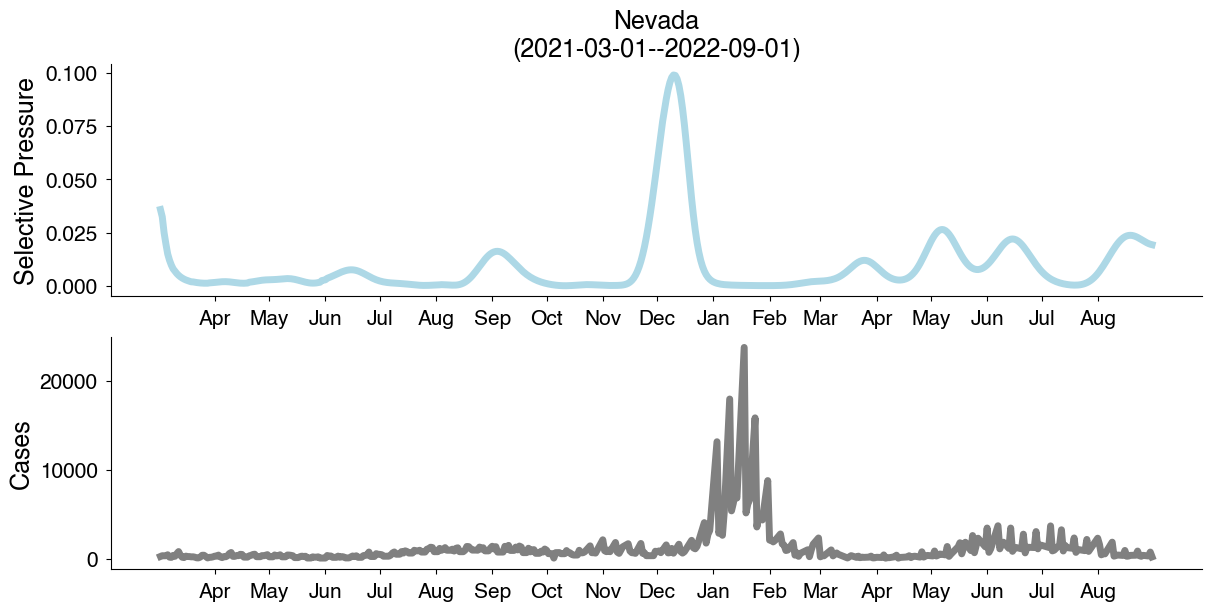

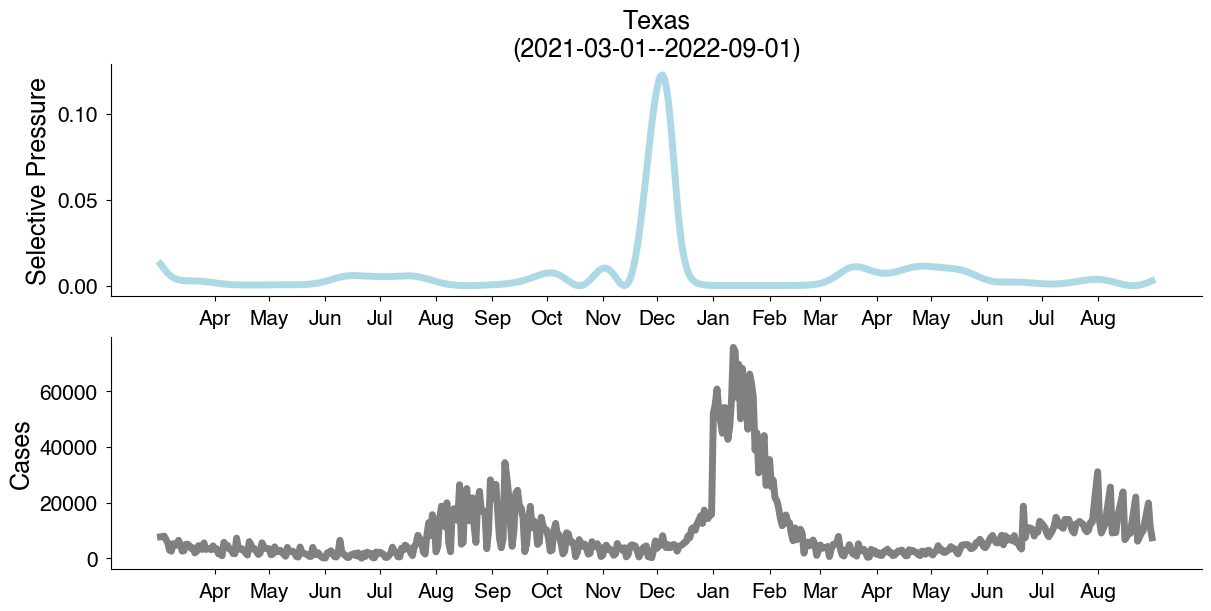

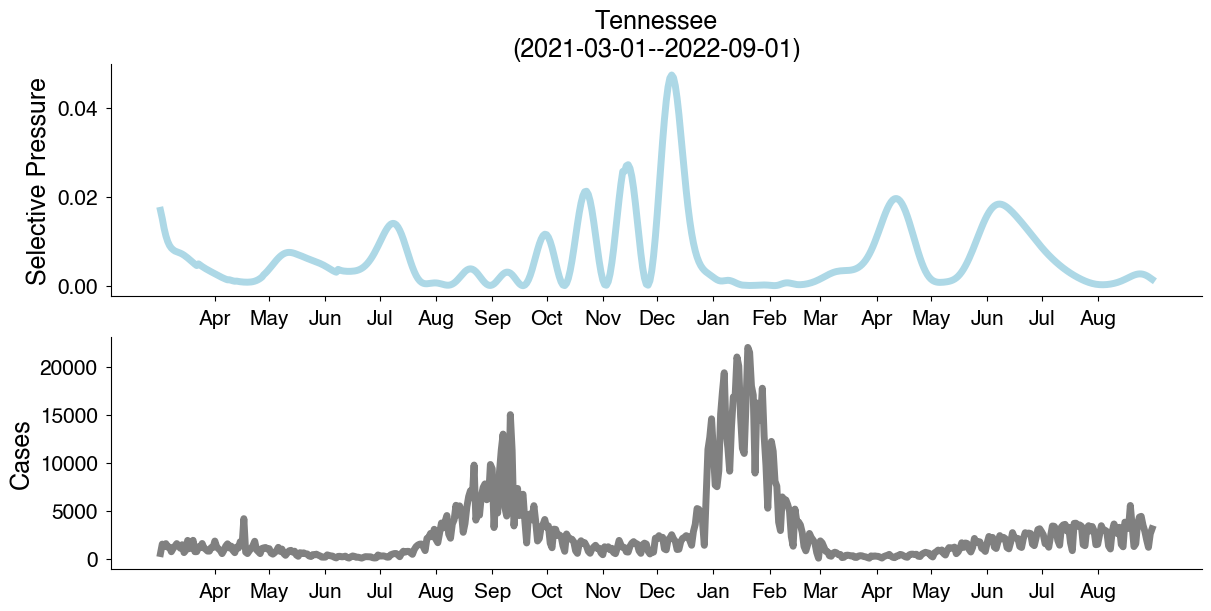

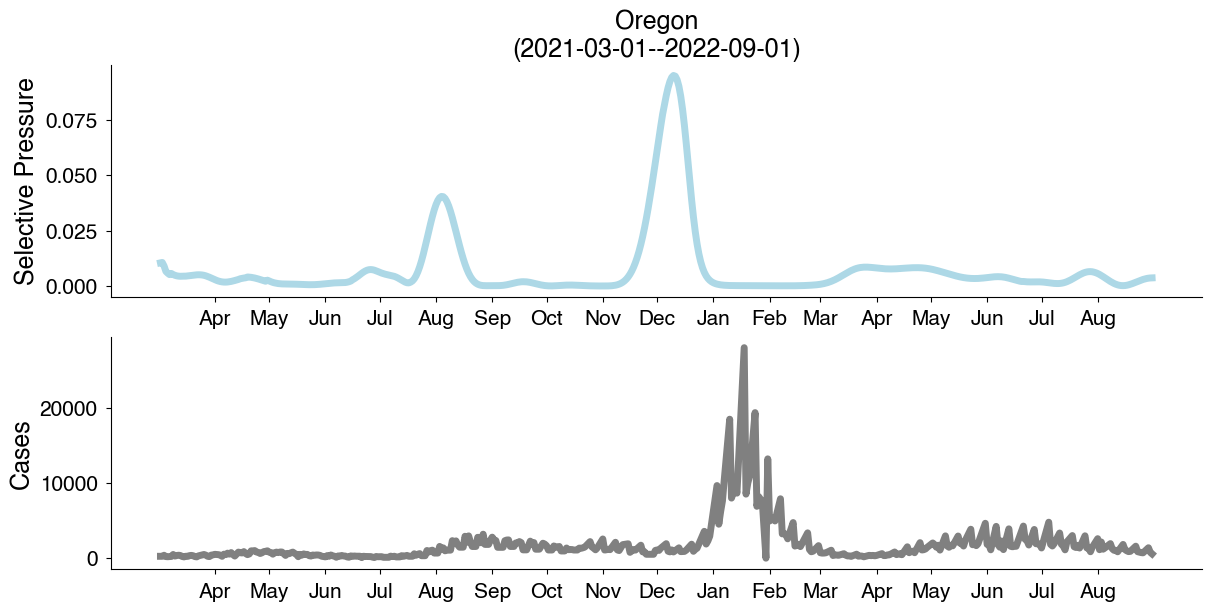

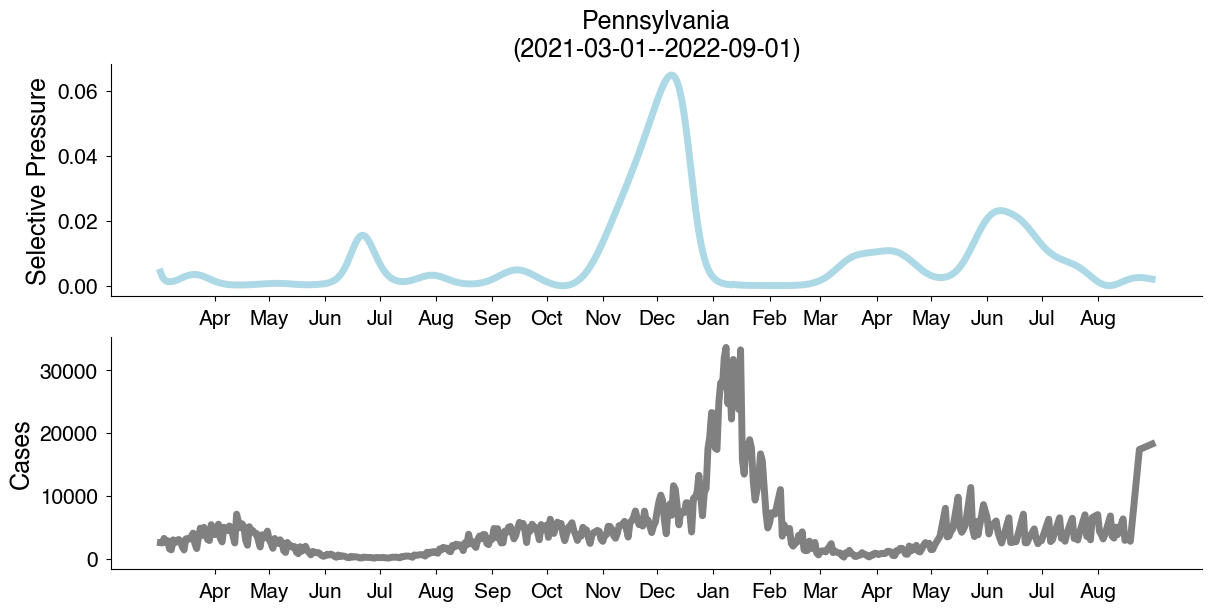

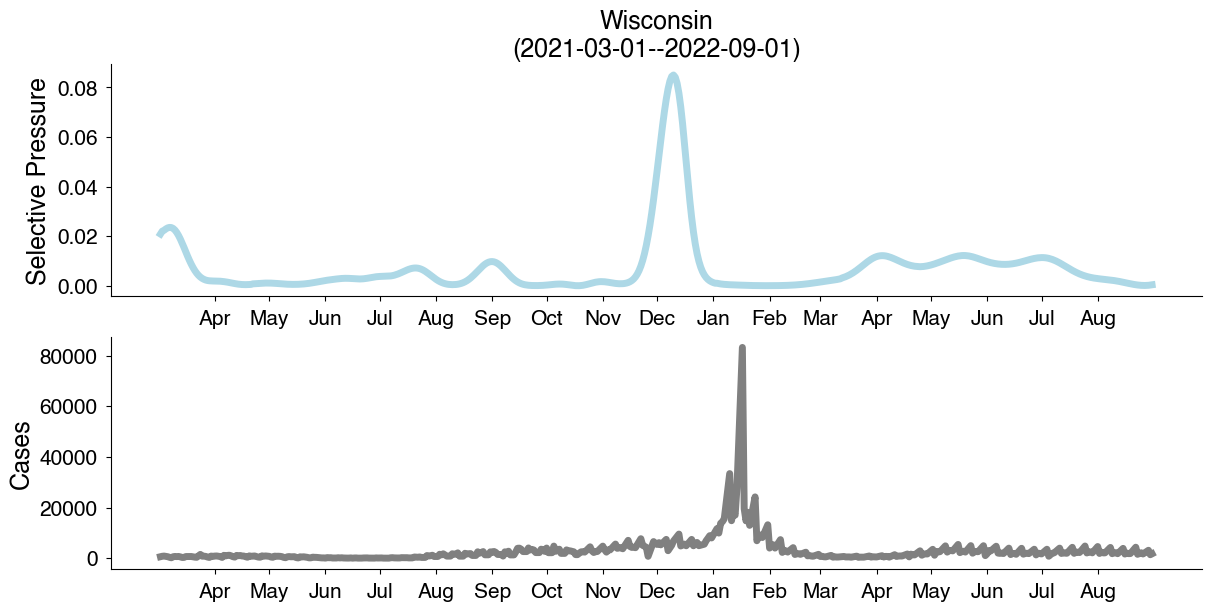

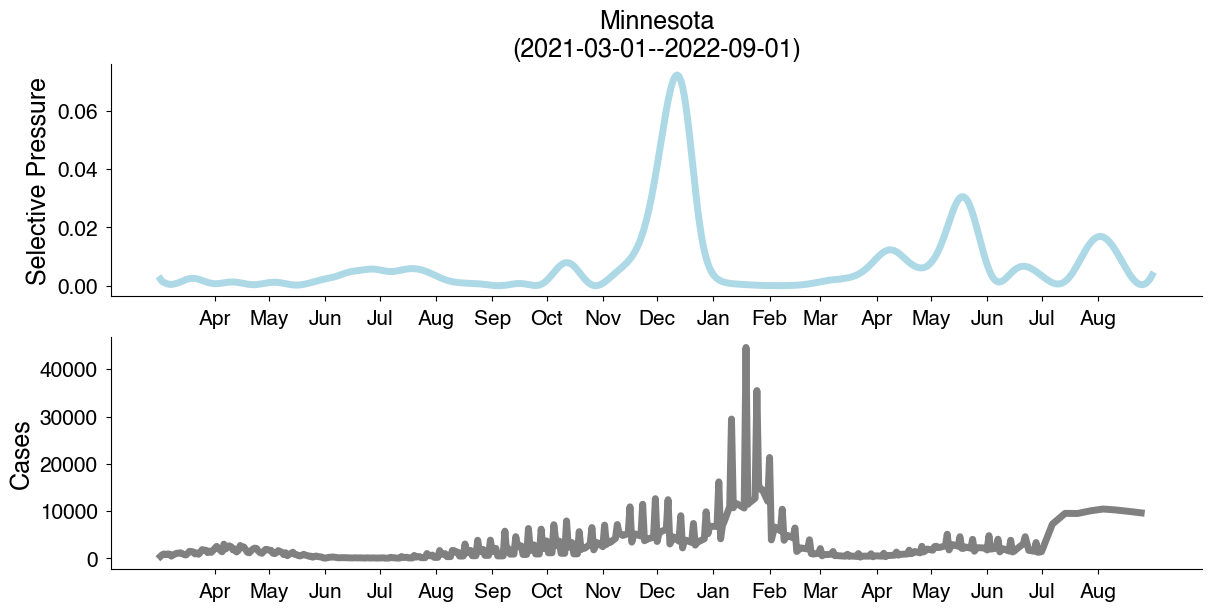

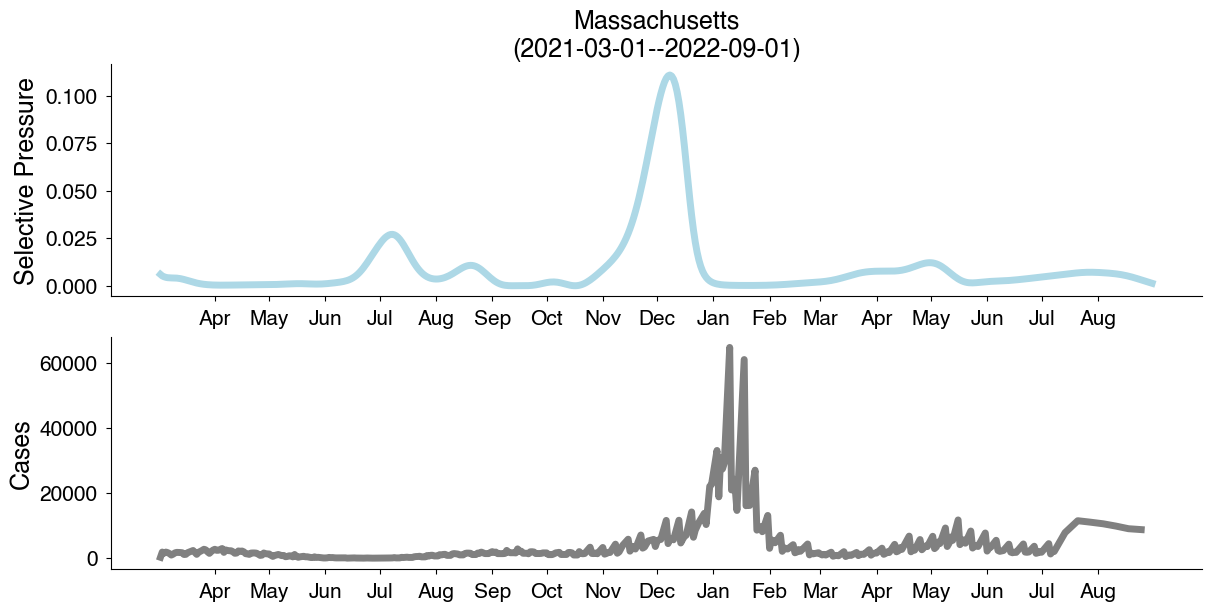

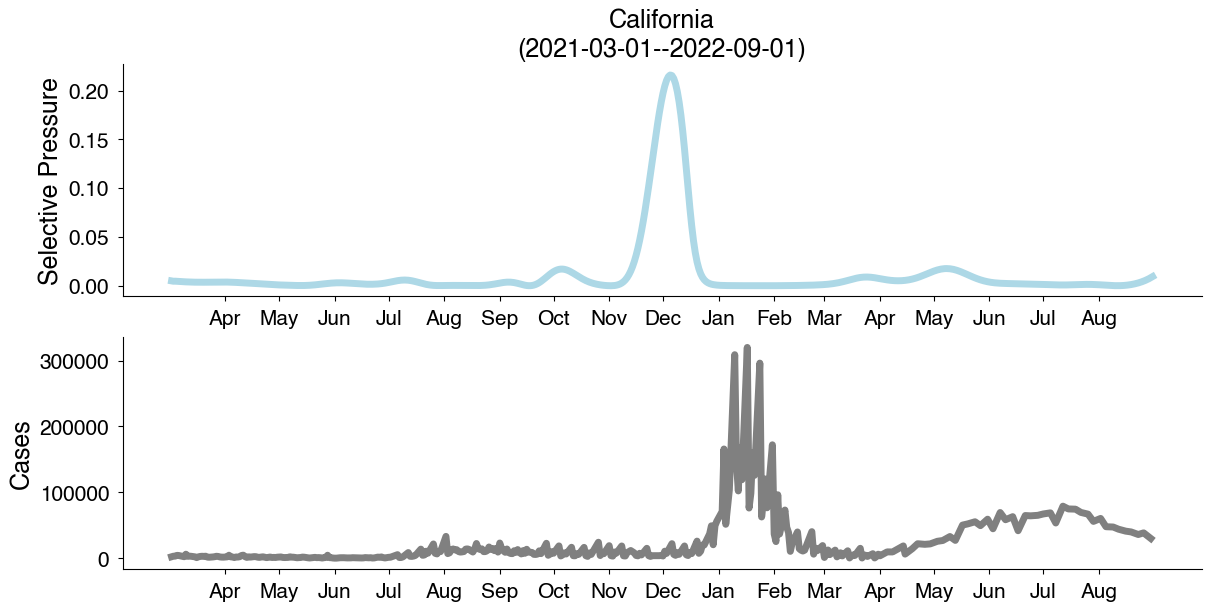

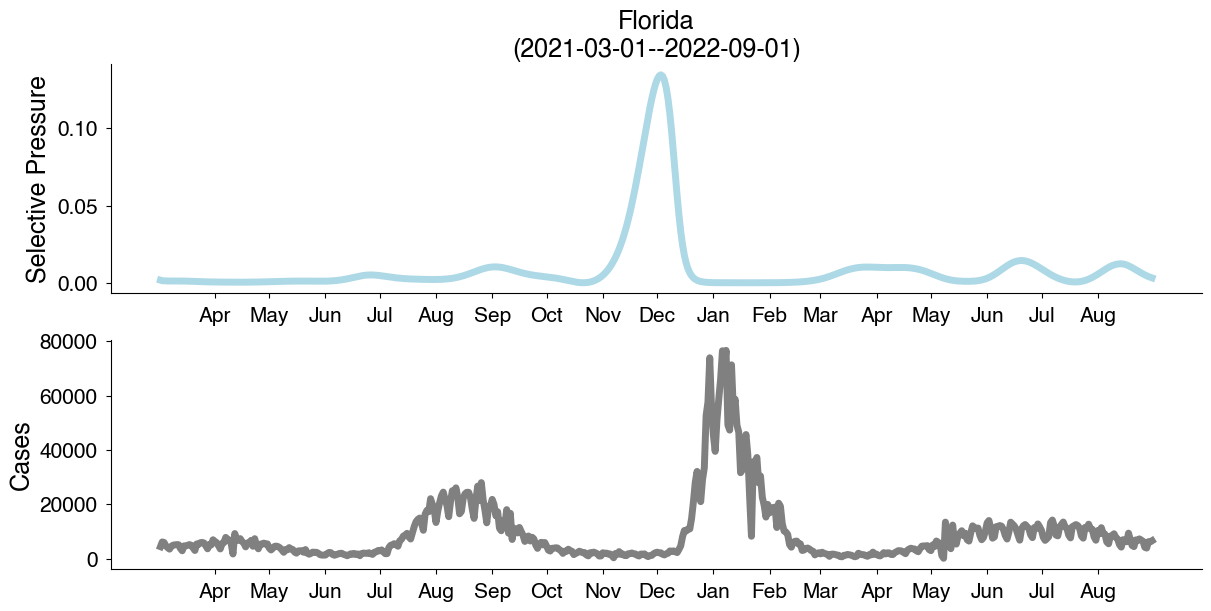

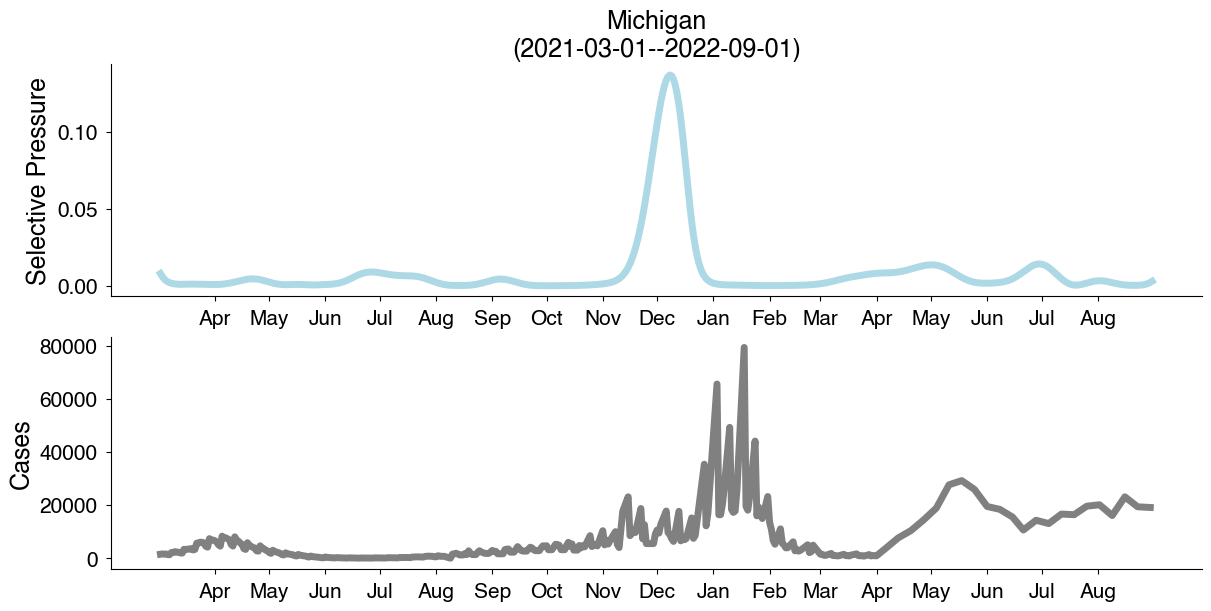

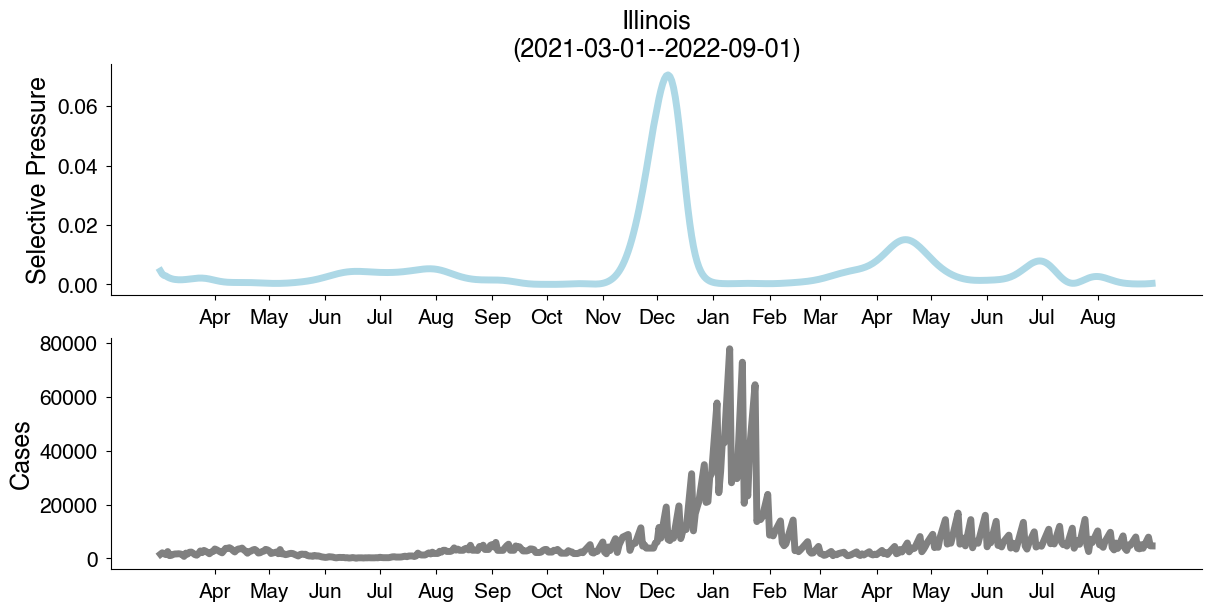

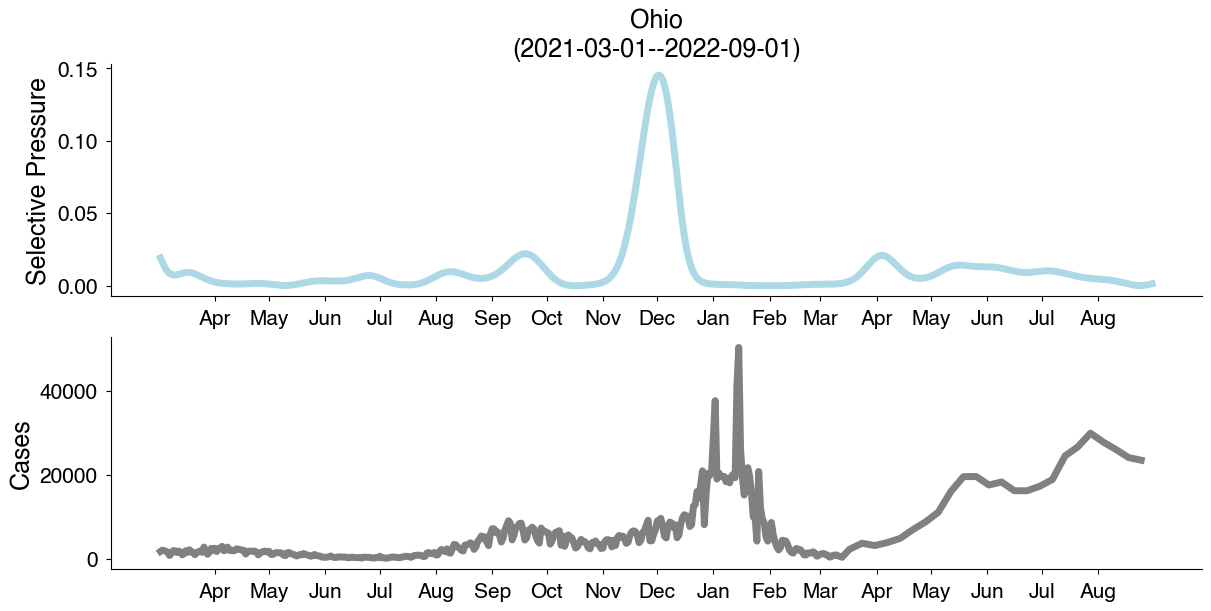

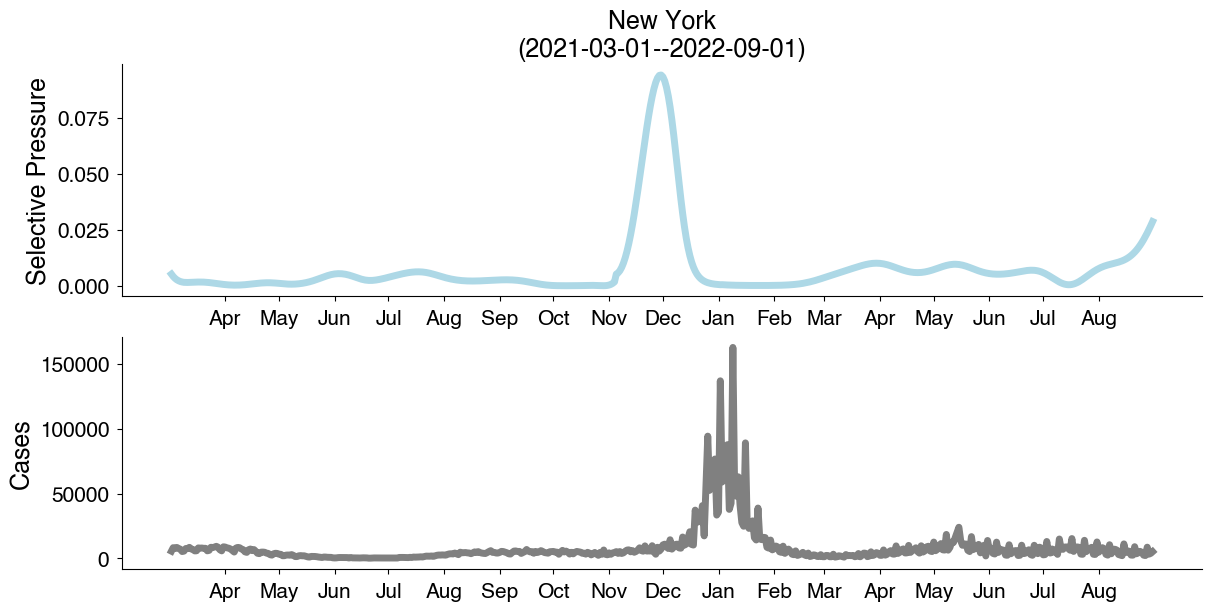

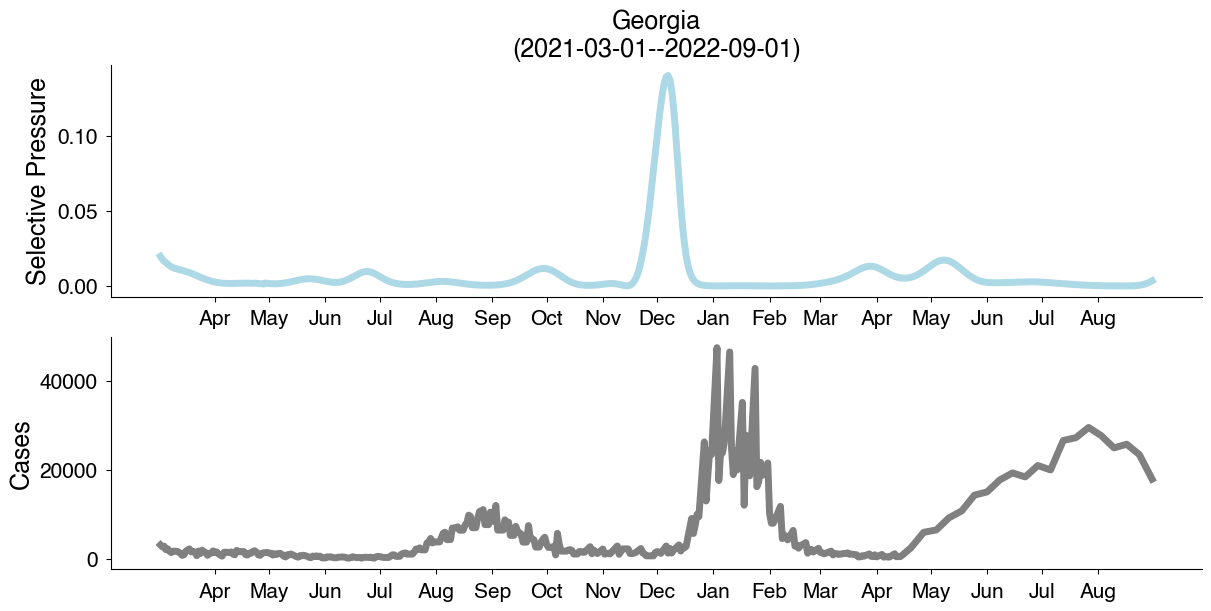

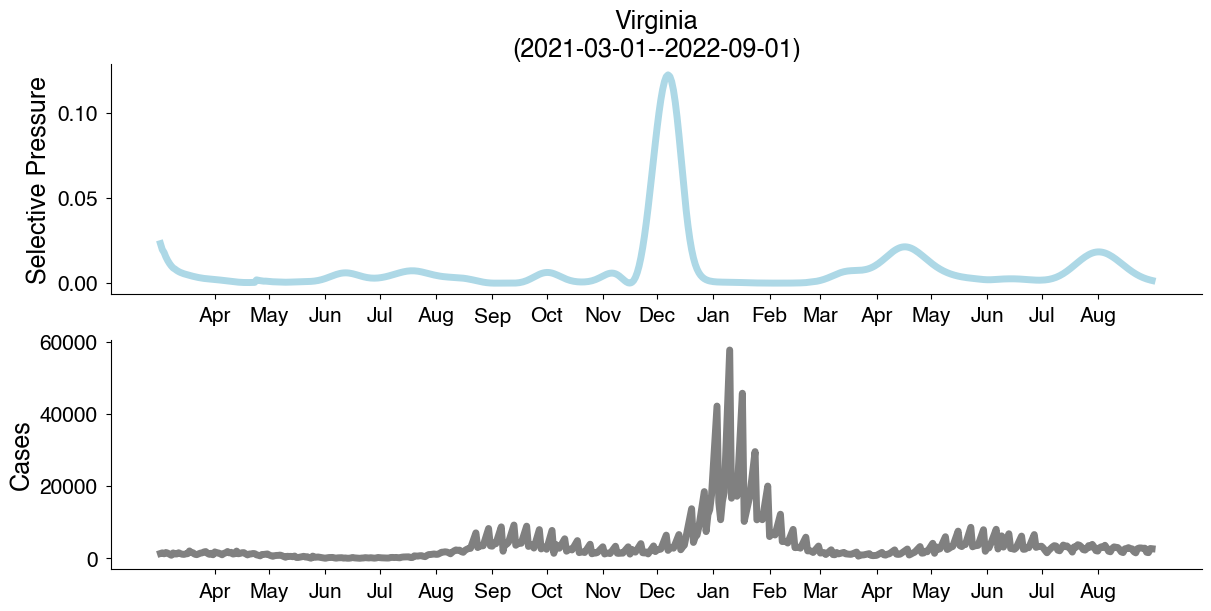

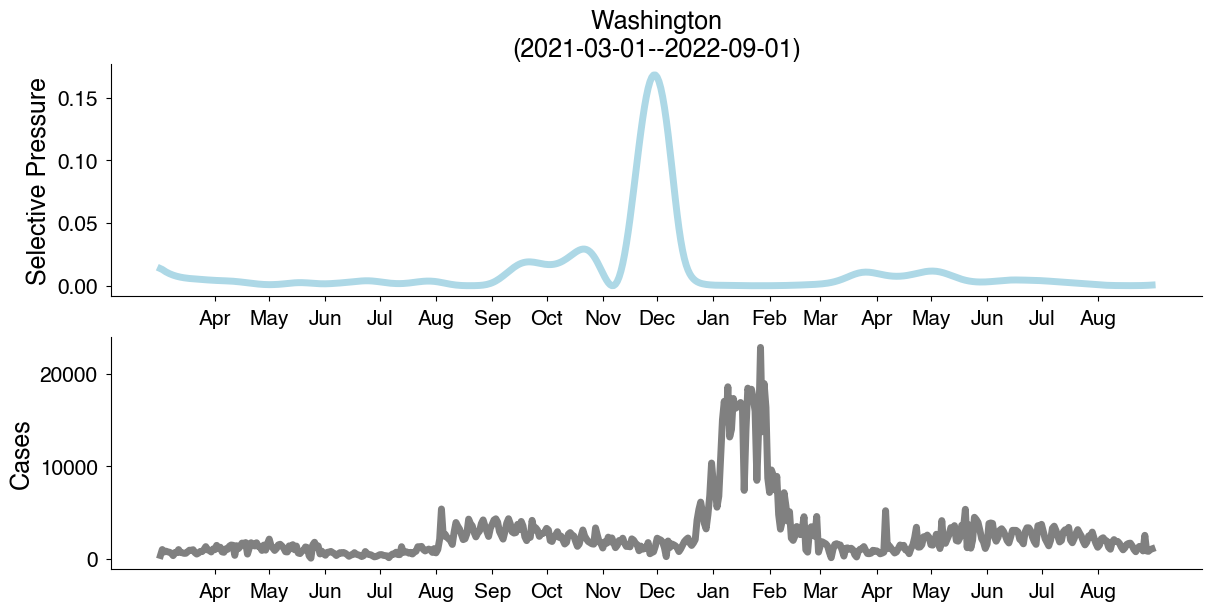

In [353]:
def plot_selective_pressure_cases(loc):
    # Compute selective pressure
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    
    fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=2)

    # Plot selective pressure
    ax0 = fig.add_subplot(spec[0, 0])
    t = np.arange(len(selective_pressure))
    ax0.plot(t, selective_pressure, color="lightblue")
    ax0.set_ylabel("Selective Pressure")
    add_dates(ax0, data[loc].dates)
    ax0.set_title(loc + f"\n({date_start}--{date_end})")

    # Plot cases
    ax1 = fig.add_subplot(spec[1, 0], sharex = ax0)
    t_cases = [i for i, t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    ax1.plot(t_cases, cases[loc].cases, color="gray")
    ax1.set_ylabel("Cases")
    return fig

fig_selective_pressure_cases = {}
for loc in locations:
    fig_selective_pressure_cases[loc] = plot_selective_pressure_cases(loc)
    fig_selective_pressure_cases[loc].savefig(f"figures/selective_pressure_cases_{loc}.png")
fig_selective_pressure_cases

{'Nevada': <Figure size 1200x600 with 2 Axes>,
 'Texas': <Figure size 1200x600 with 2 Axes>,
 'Tennessee': <Figure size 1200x600 with 2 Axes>,
 'Oregon': <Figure size 1200x600 with 2 Axes>,
 'Pennsylvania': <Figure size 1200x600 with 2 Axes>,
 'Wisconsin': <Figure size 1200x600 with 2 Axes>,
 'Minnesota': <Figure size 1200x600 with 2 Axes>,
 'Massachusetts': <Figure size 1200x600 with 2 Axes>,
 'California': <Figure size 1200x600 with 2 Axes>,
 'Florida': <Figure size 1200x600 with 2 Axes>,
 'Michigan': <Figure size 1200x600 with 2 Axes>,
 'Illinois': <Figure size 1200x600 with 2 Axes>,
 'Ohio': <Figure size 1200x600 with 2 Axes>,
 'New York': <Figure size 1200x600 with 2 Axes>,
 'Georgia': <Figure size 1200x600 with 2 Axes>,
 'Virginia': <Figure size 1200x600 with 2 Axes>,
 'Washington': <Figure size 1200x600 with 2 Axes>}

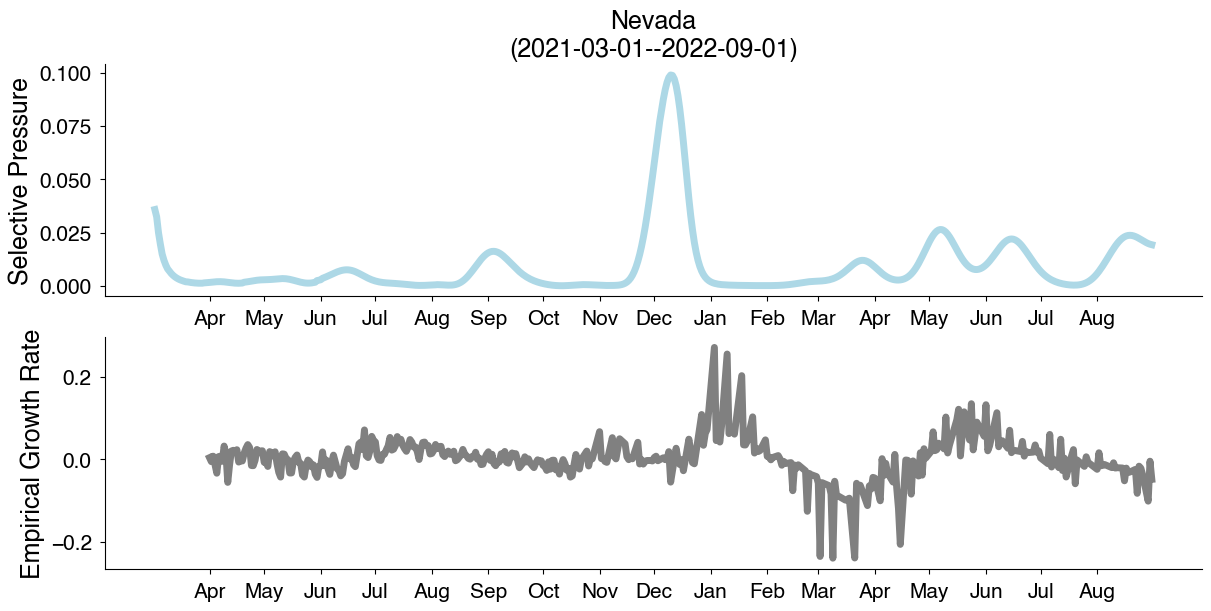

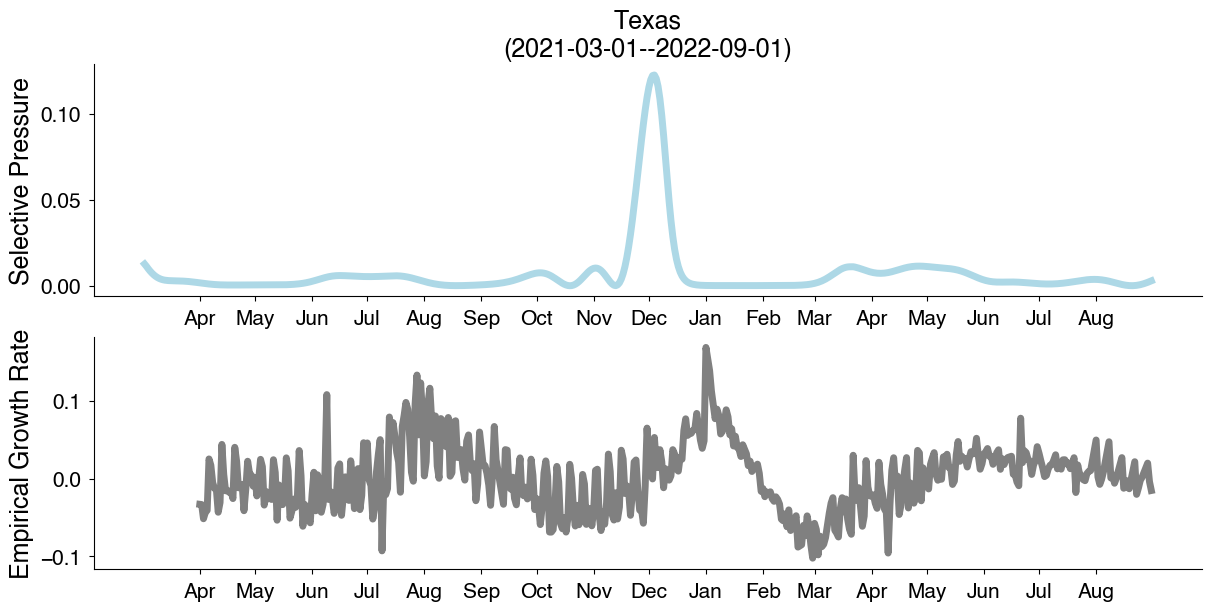

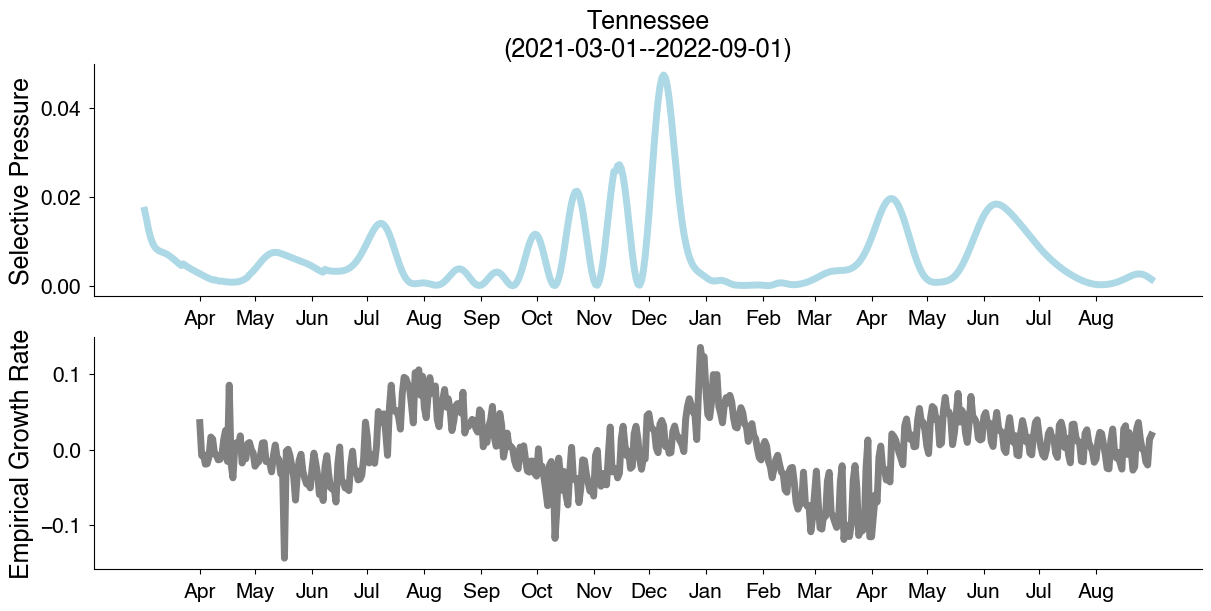

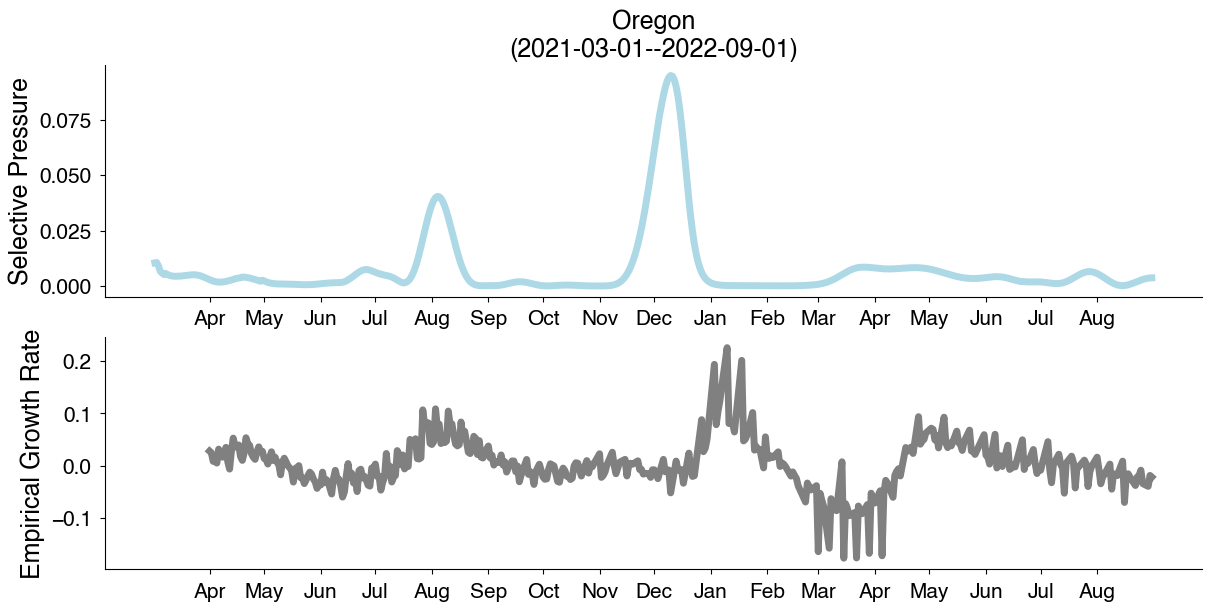

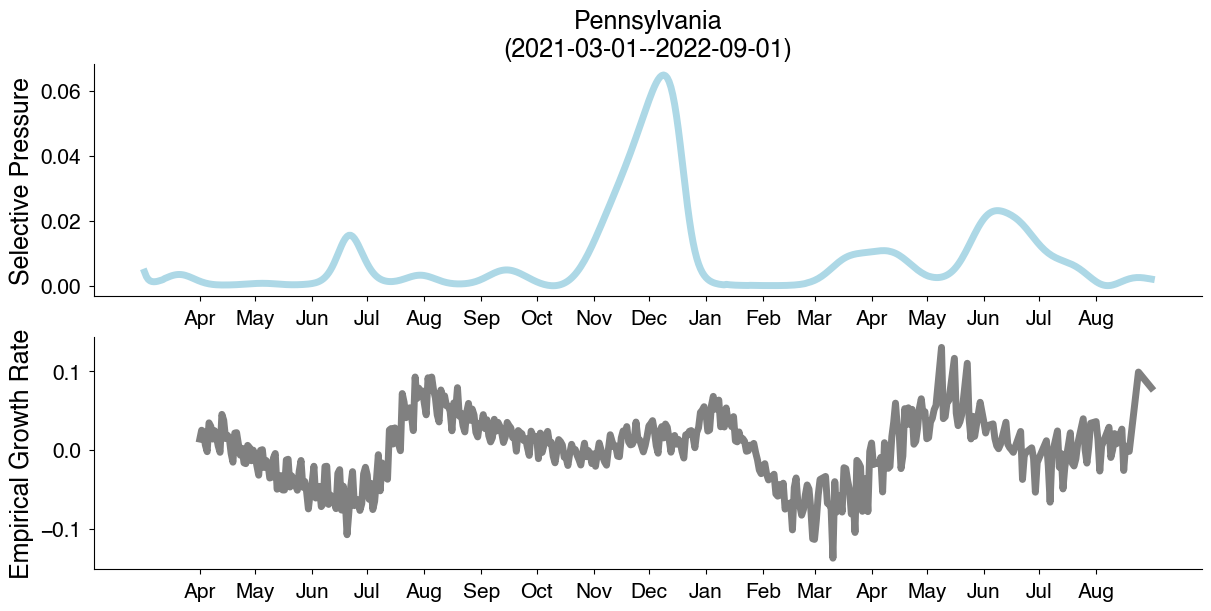

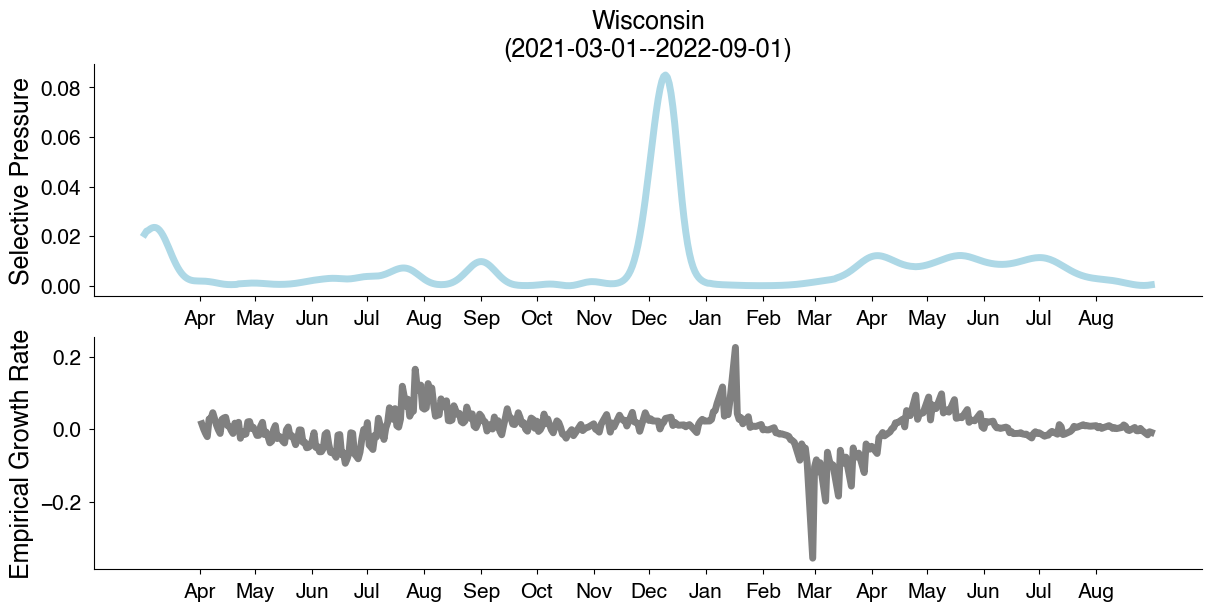

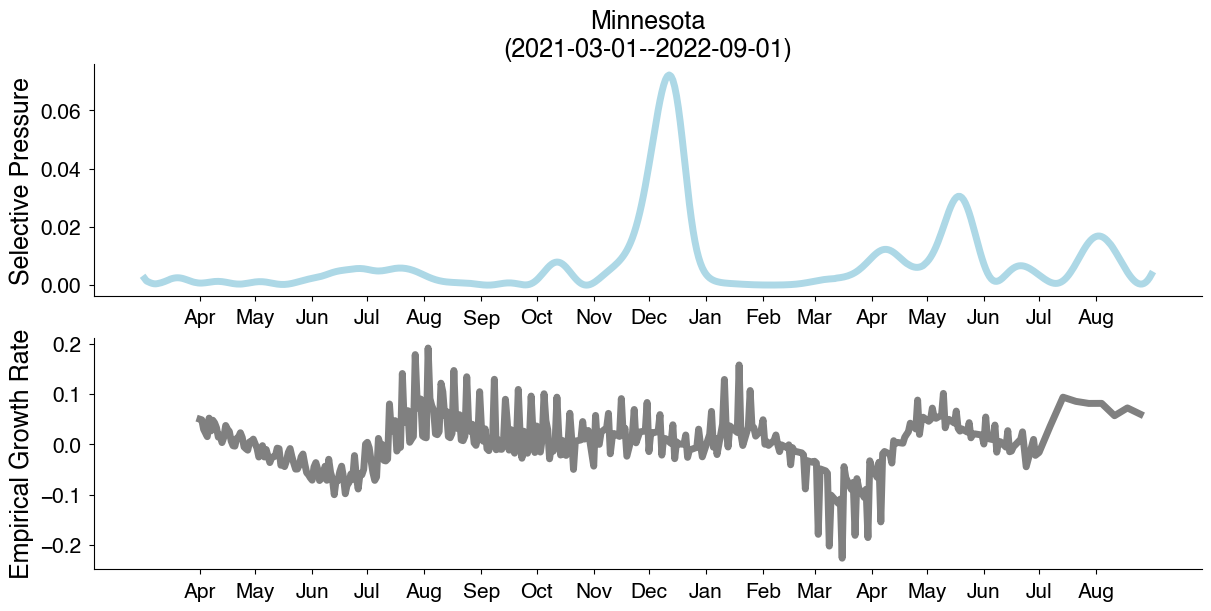

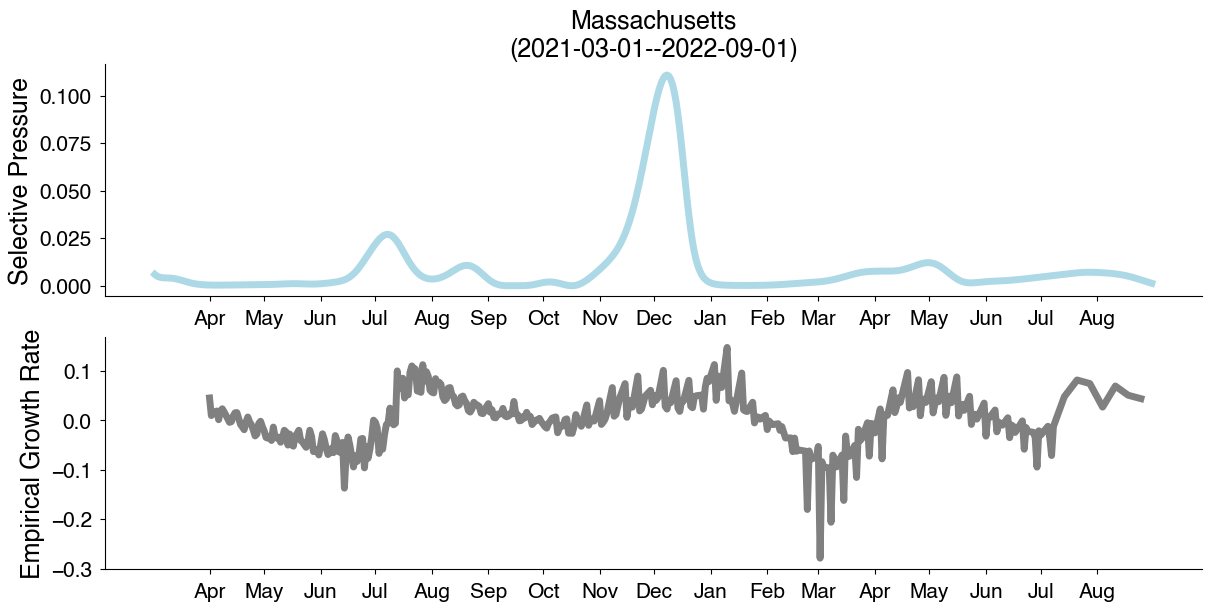

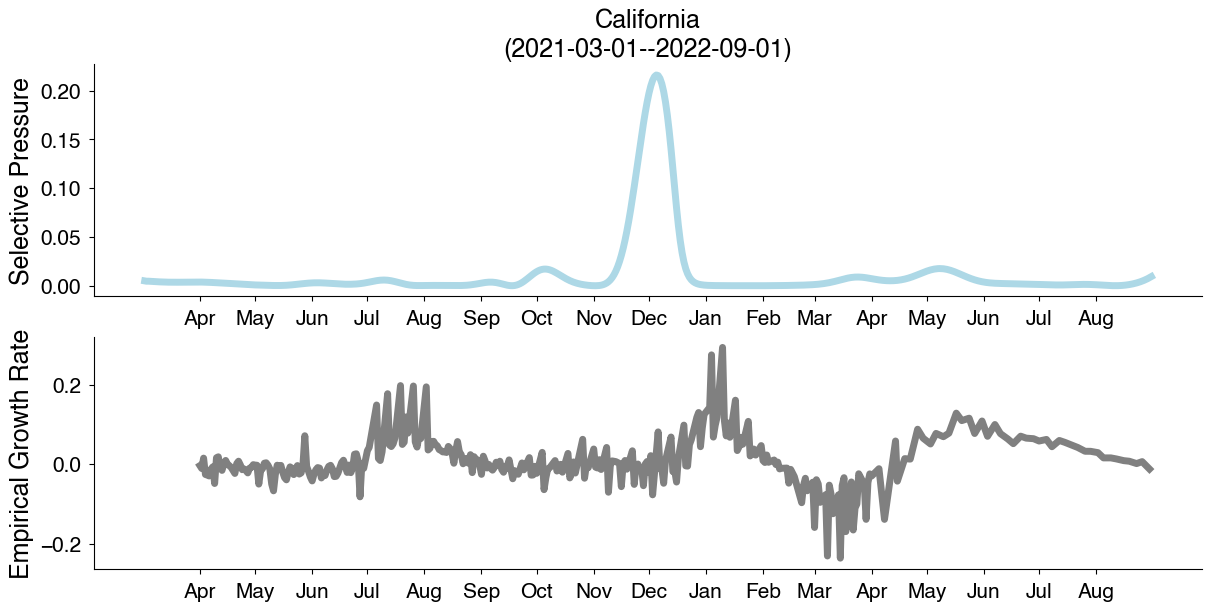

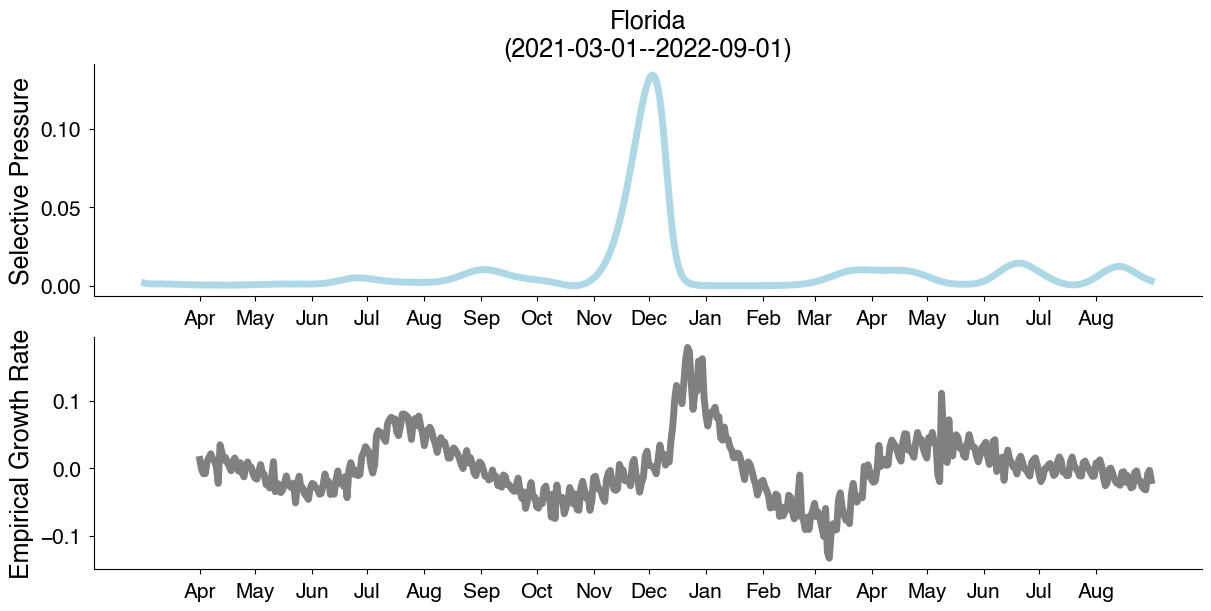

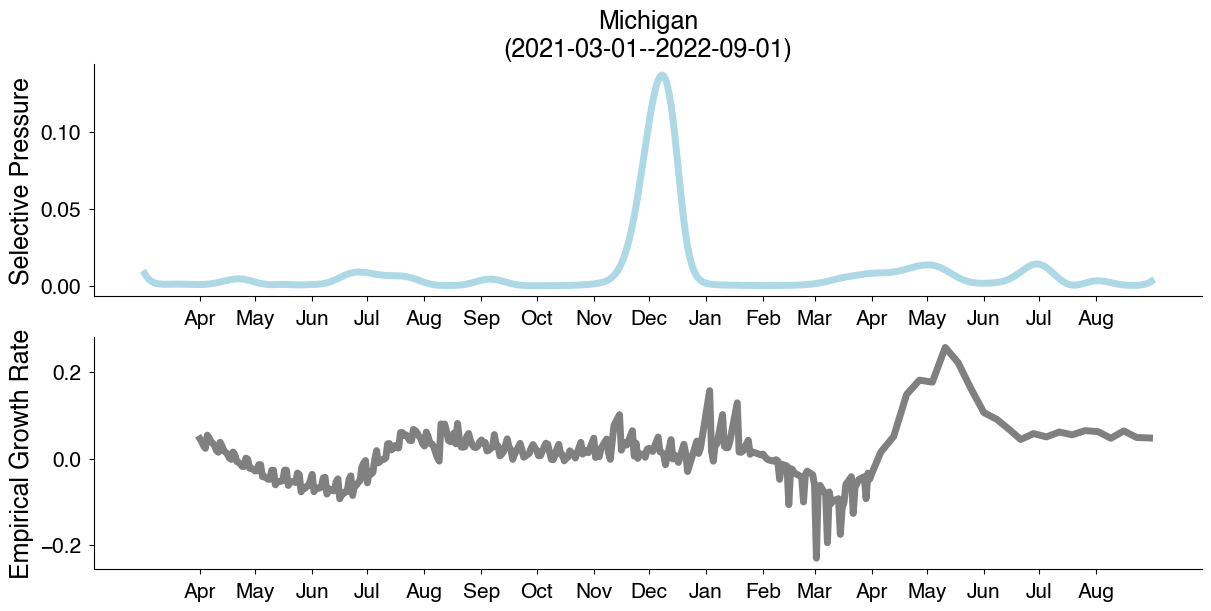

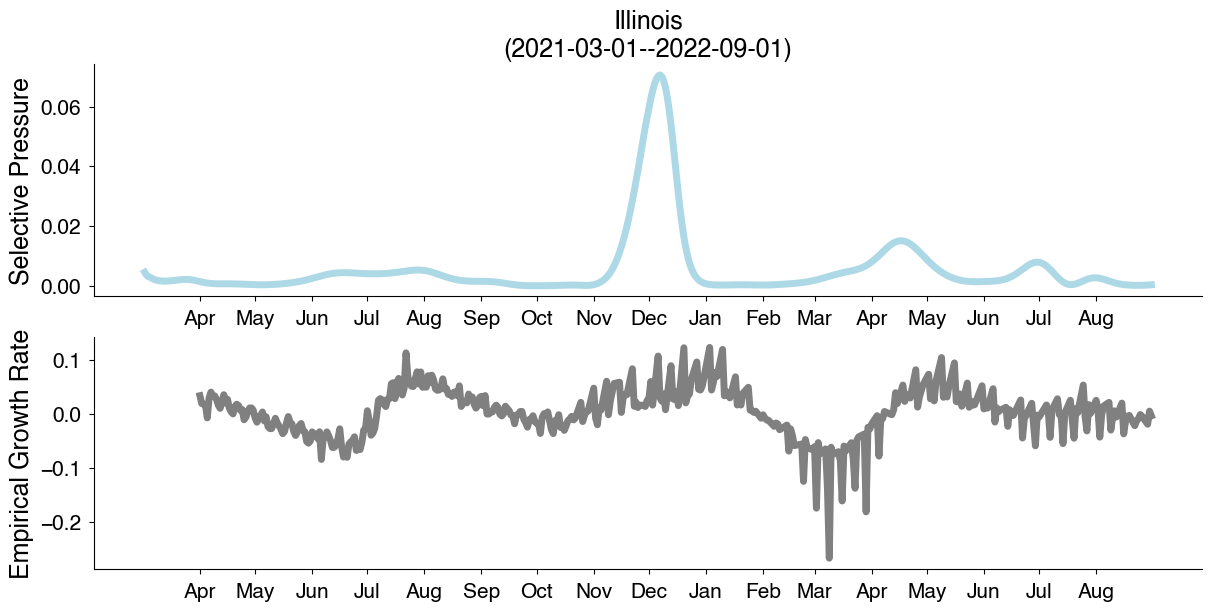

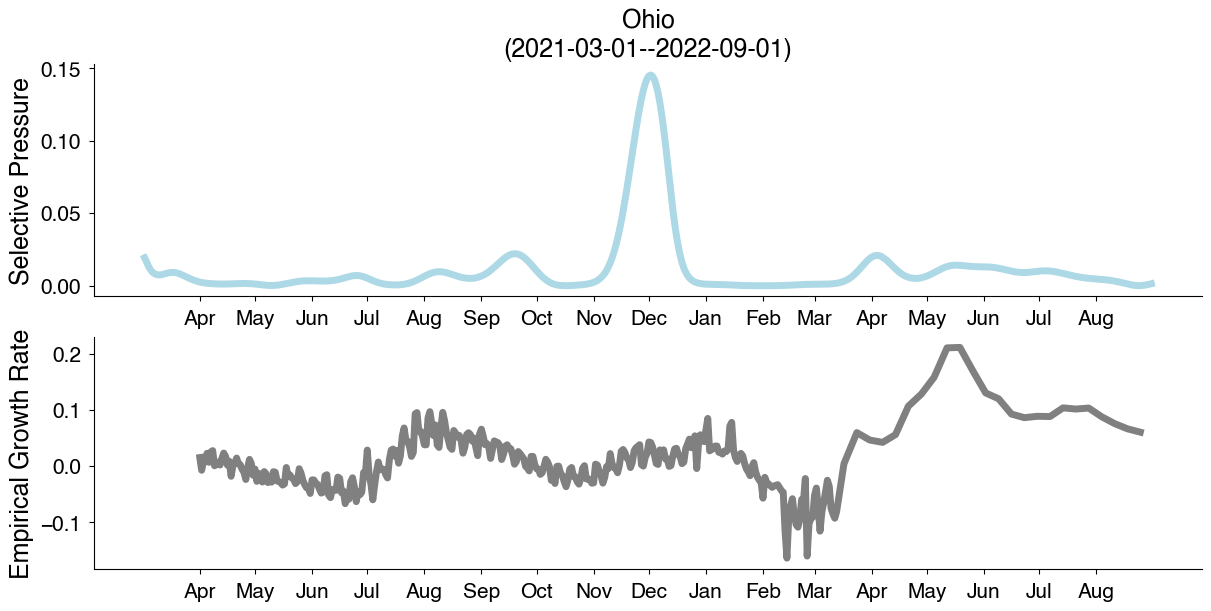

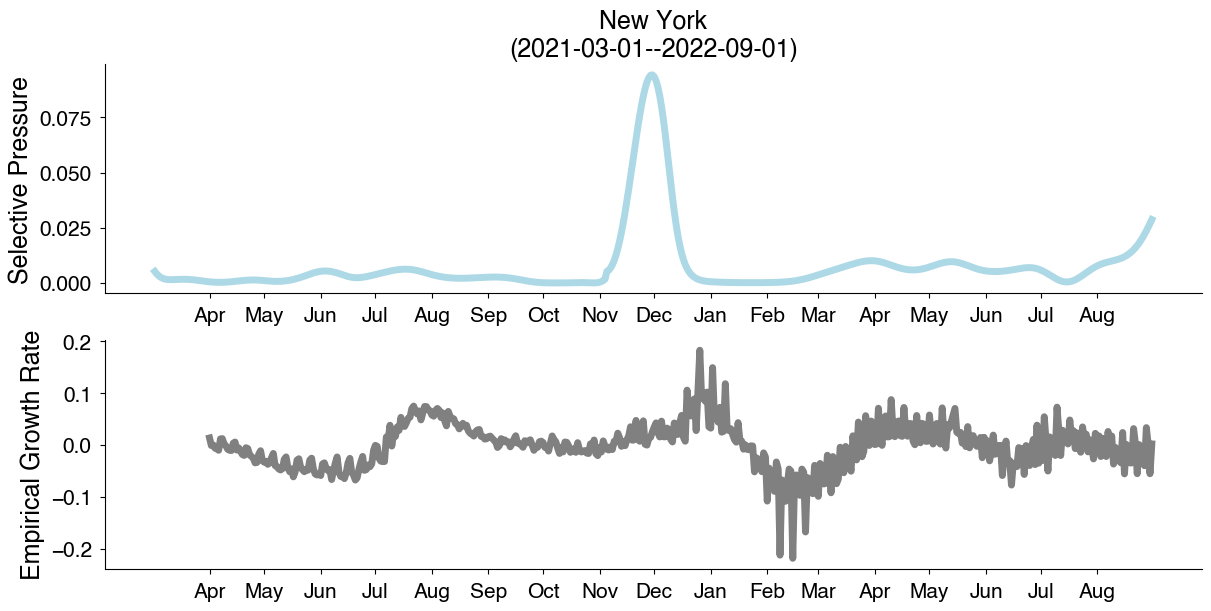

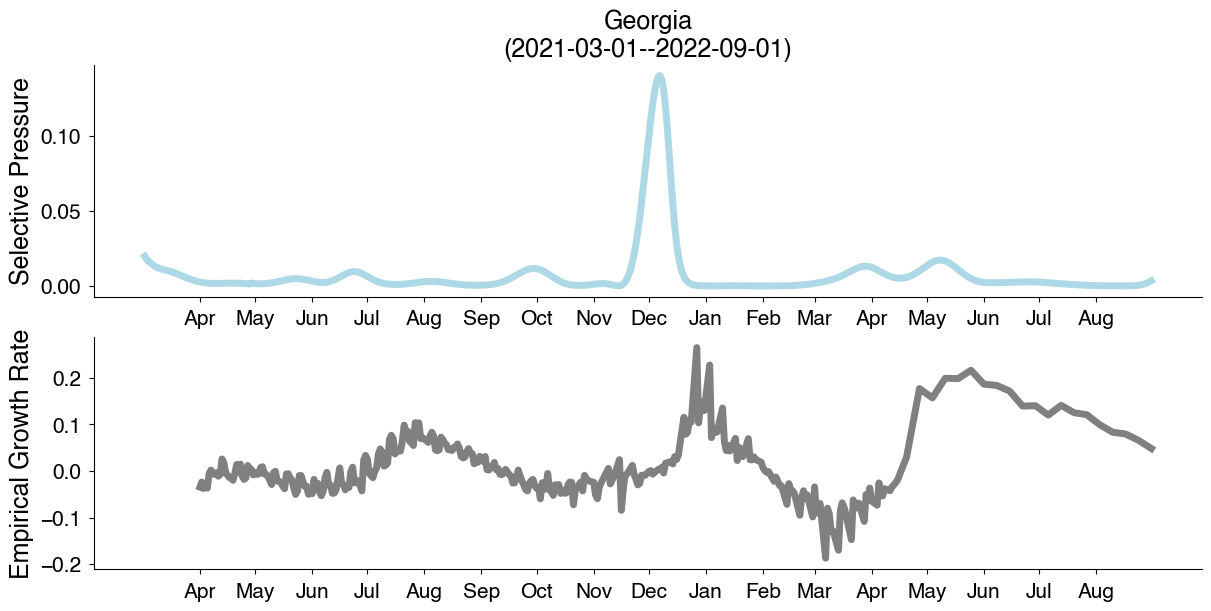

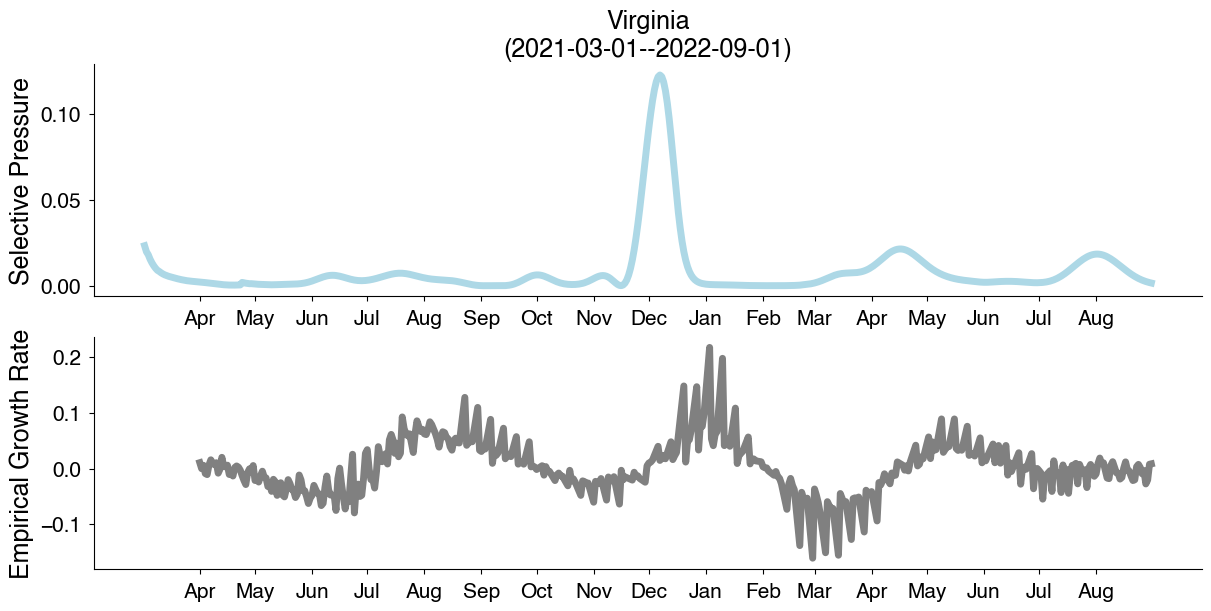

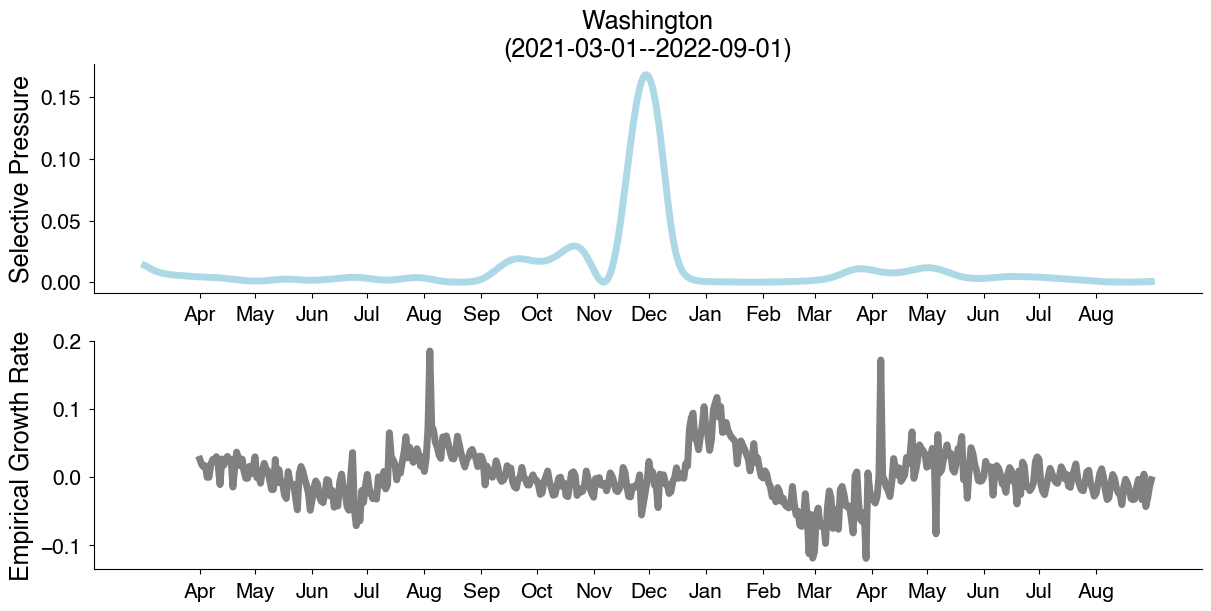

In [354]:
def moving_average(a, n=3):
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_selective_pressure_growth(loc, window_n):
    # Compute selective pressure
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    
    # Prep data
    t_cases = [i for i, t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    smooth_cases = moving_average(cases[loc].cases.values, n=window_n)
    empirical_growth = np.diff(np.log(smooth_cases))
    
    fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=2)

    # Plot selective pressure
    ax0 = fig.add_subplot(spec[0, 0])
    t = np.arange(len(selective_pressure))
    ax0.plot(t, selective_pressure, color="lightblue")
    ax0.set_ylabel("Selective Pressure")
    add_dates(ax0, data[loc].dates)
    ax0.set_title(loc + f"\n({date_start}--{date_end})")

    # Plot empirical growth rates
    ax1 = fig.add_subplot(spec[1, 0], sharex = ax0)
    ax1.plot(t_cases[window_n:], empirical_growth, color="gray")
    ax1.set_ylabel("Empirical Growth Rate")
    return fig

window_n = 30
fig_selective_pressure_growth = {}
for loc in locations:
    fig_selective_pressure_growth[loc] = plot_selective_pressure_growth(loc, window_n)
    fig_selective_pressure_growth[loc].savefig(f"figures/selective_pressure_growth_{loc}.png")
fig_selective_pressure_growth

In [355]:
def make_dataframes(loc):
    # Create selective pressure column for each date
    delta_bar, selective_pressure = compute_selective_pressure(posteriors[loc])
    selective_pressure_df = pd.DataFrame({"selective_pressure": selective_pressure[:,-1], "date": data[loc].dates})
    
    # Create smooth cases and empirical growth dataframe
    t_cases = [t for i,t in enumerate(data[loc].dates) if t in pd.to_datetime(cases[loc].date.values)]
    smooth_cases = moving_average(cases[loc].cases.values, n=window_n)
    empirical_growth = np.diff(np.log(smooth_cases), prepend=np.nan)
    empirical_growth_change = np.diff(empirical_growth, prepend=np.nan)
    
    growth_df = pd.DataFrame({"date": t_cases[window_n-1:], 
                              "smooth_cases": smooth_cases, 
                              "empirical_growth_rate": empirical_growth,
                              "empirical_growth_change": empirical_growth_change
                             })
    # Merge on date
    selective_pressure_df = selective_pressure_df.merge(growth_df, on="date", how="left")
    selective_pressure_df["location"] = loc
    return selective_pressure_df

selective_pressure_dfs = {}
for loc in locations:
    selective_pressure_dfs[loc] = make_dataframes(loc)

selective_pressure_dfs["Washington"]

selective_pressure       date  smooth_cases  empirical_growth_rate  \
0              0.013668 2021-03-02           NaN                    NaN   
1              0.013004 2021-03-03           NaN                    NaN   
2              0.012003 2021-03-04           NaN                    NaN   
3              0.011101 2021-03-05           NaN                    NaN   
4              0.010317 2021-03-06           NaN                    NaN   
..                  ...        ...           ...                    ...   
543            0.000279 2022-08-27   1613.133333               0.004328   
544            0.000334 2022-08-28   1545.000000              -0.043155   
545            0.000401 2022-08-29   1497.800000              -0.031027   
546            0.000481 2022-08-30   1475.766667              -0.014820   
547            0.000578 2022-08-31   1470.100000              -0.003847   

     empirical_growth_change    location  
0                        NaN  Washington  
1                        NaN  Washington  
2                        NaN  Washington  
3                        NaN  Washington  
4                        NaN  Washington  
..                       ...         ...  
543                 0.037436  Washington  
544                -0.047483  Washington  
545                 0.012128  Washington  
546                 0.016207  Washington  
547                 0.010973  Washington  

[548 rows x 6 columns]

In [356]:
def create_lagged_features(df, columns, max_lag, dropna=True):
    """
    Generate lagged predictors for specified columns in a pandas DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the original data.
    - columns: list of column names for which to generate lagged predictors.
    - max_lag: maximum number of lags to generate.
    - dropna: boolean indicating whether to drop rows with NaN values resulting from lagging.
    
    Returns:
    - A pandas DataFrame with original and lagged predictors.
    """
    result_df = df.copy()
    for col in columns:
        for lag in range(1, max_lag + 1):
            result_df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    if dropna:
        result_df = result_df.dropna().reset_index(drop=True)
    
    return result_df

input_dfs = {}
TARGET = "empirical_growth_rate"
keep_features = ["date", "location", "selective_pressure"]
keep_targets = [TARGET]
for loc in locations:
    input_dfs[loc] = create_lagged_features(
        selective_pressure_dfs[loc][keep_features + keep_targets], 
        ["selective_pressure"], 
        60)

input_dfs["California"]

date    location  selective_pressure  empirical_growth_rate  \
0   2021-05-01  California            0.000875              -0.002010   
1   2021-05-02  California            0.000806              -0.002303   
2   2021-05-03  California            0.000741              -0.049698   
3   2021-05-04  California            0.000678              -0.016042   
4   2021-05-05  California            0.000616              -0.011203   
..         ...         ...                 ...                    ...   
308 2022-08-16  California            0.000503               0.009177   
309 2022-08-19  California            0.001242               0.007694   
310 2022-08-23  California            0.002923               0.001806   
311 2022-08-26  California            0.004799               0.006693   
312 2022-08-30  California            0.008329              -0.011937   

     selective_pressure_lag_1  selective_pressure_lag_2  \
0                    0.000948                  0.001027   
1                    0.000875                  0.000948   
2                    0.000806                  0.000875   
3                    0.000741                  0.000806   
4                    0.000678                  0.000741   
..                        ...                       ...   
308                  0.000346                  0.000229   
309                  0.000949                  0.000703   
310                  0.002421                  0.001975   
311                  0.004108                  0.003484   
312                  0.007321                  0.006400   

     selective_pressure_lag_3  selective_pressure_lag_4  \
0                    0.001114                  0.001209   
1                    0.001027                  0.001114   
2                    0.000948                  0.001027   
3                    0.000875                  0.000948   
4                    0.000806                  0.000875   
..                        ...                       ...   
308                  0.000152                  0.000112   
309                  0.000503                  0.000346   
310                  0.001583                  0.001242   
311                  0.002923                  0.002421   
312                  0.005561                  0.004799   

     selective_pressure_lag_5  selective_pressure_lag_6  ...  \
0                    0.001313                  0.001424  ...   
1                    0.001209                  0.001313  ...   
2                    0.001114                  0.001209  ...   
3                    0.001027                  0.001114  ...   
4                    0.000948                  0.001027  ...   
..                        ...                       ...  ...   
308                  0.000106                  0.000130  ...   
309                  0.000229                  0.000152  ...   
310                  0.000949                  0.000703  ...   
311                  0.001975                  0.001583  ...   
312                  0.004108                  0.003484  ...   

     selective_pressure_lag_51  selective_pressure_lag_52  \
0                     0.003927                   0.004013   
1                     0.003850                   0.003927   
2                     0.003787                   0.003850   
3                     0.003733                   0.003787   
4                     0.003692                   0.003733   
..                         ...                        ...   
308                   0.001698                   0.001749   
309                   0.001525                   0.001586   
310                   0.001255                   0.001325   
311                   0.001050                   0.001116   
312                   0.000861                   0.000894   

     selective_pressure_lag_53  selective_pressure_lag_54  \
0                     0.004111                   0.004218   
1                     0.004013                   0.004111   
2                     0.003927

In [434]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # For regression
from sklearn.metrics import mean_squared_error

def process_inputs(loc, target):
    X = input_dfs[loc].drop(target, axis=1)  # Features
    y = input_dfs[loc][target]  # Target
    if "date" in X.columns:
        X.drop("date", axis=1)
    return X, y

def process_inputs_all(locations, target):
    Xs, ys = [], []
    input_df = pd.concat([df for _, df in input_dfs.items()])
    X = input_df.sort_values(["date"]).reset_index(drop=True)
    dates = X["date"]
    locations = X["location"]
    
    y = X[target]  # Target
    #X = X.drop([target], axis=1) #"date", "location"], axis=1)  # Features
    X = X.drop([target, "date", "location"], axis=1)  # Features

    return dates, locations, X, y
    
dates_vec, locations_vec, X, y = process_inputs_all(locations, target=TARGET)

# Split to hold final section for testing best model after CV
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

#print(X.date, X_test.date)

#print((pd.concat((X, X_test)).location.values == locations_vec).all())
#print((pd.concat((X, X_test)).date.values == dates_vec).all())

# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1e-2),
    'Lasso': Lasso(alpha=1e-6),
    'RandomForest': RandomForestRegressor(n_estimators=30),
    'GradientBoosting': GradientBoostingRegressor(loss="absolute_error", n_estimators=30)
}
model_scores = {model: [] for model in models}

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Example: Iterate over the splits and print the train/val indices
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize and train your linear model within each split
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        mse = mean_squared_error(y_val, predictions)
        
        # Append the MSE to the model's list of scores
        model_scores[model_name].append(mse)

for model_name, scores in model_scores.items():
    print(f"{model_name}: Mean MSE = {np.mean(scores):.4f}, Std MSE = {np.std(scores):.4f}")
    
best_model_name = min(model_scores, key=lambda k: np.mean(model_scores[k]))

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.615e-03, tolerance: 7.203e-04
  model = cd_fast.enet_coordinate_descent(


LinearRegression: Mean MSE = 0.0047, Std MSE = 0.0027
Ridge: Mean MSE = 0.0042, Std MSE = 0.0020
Lasso: Mean MSE = 0.0043, Std MSE = 0.0019
RandomForest: Mean MSE = 0.0030, Std MSE = 0.0012
GradientBoosting: Mean MSE = 0.0027, Std MSE = 0.0010


In [435]:
# Retrain best model
best_model = models[best_model_name]
best_model.fit(X, y)
predictions = best_model.predict(X_test)

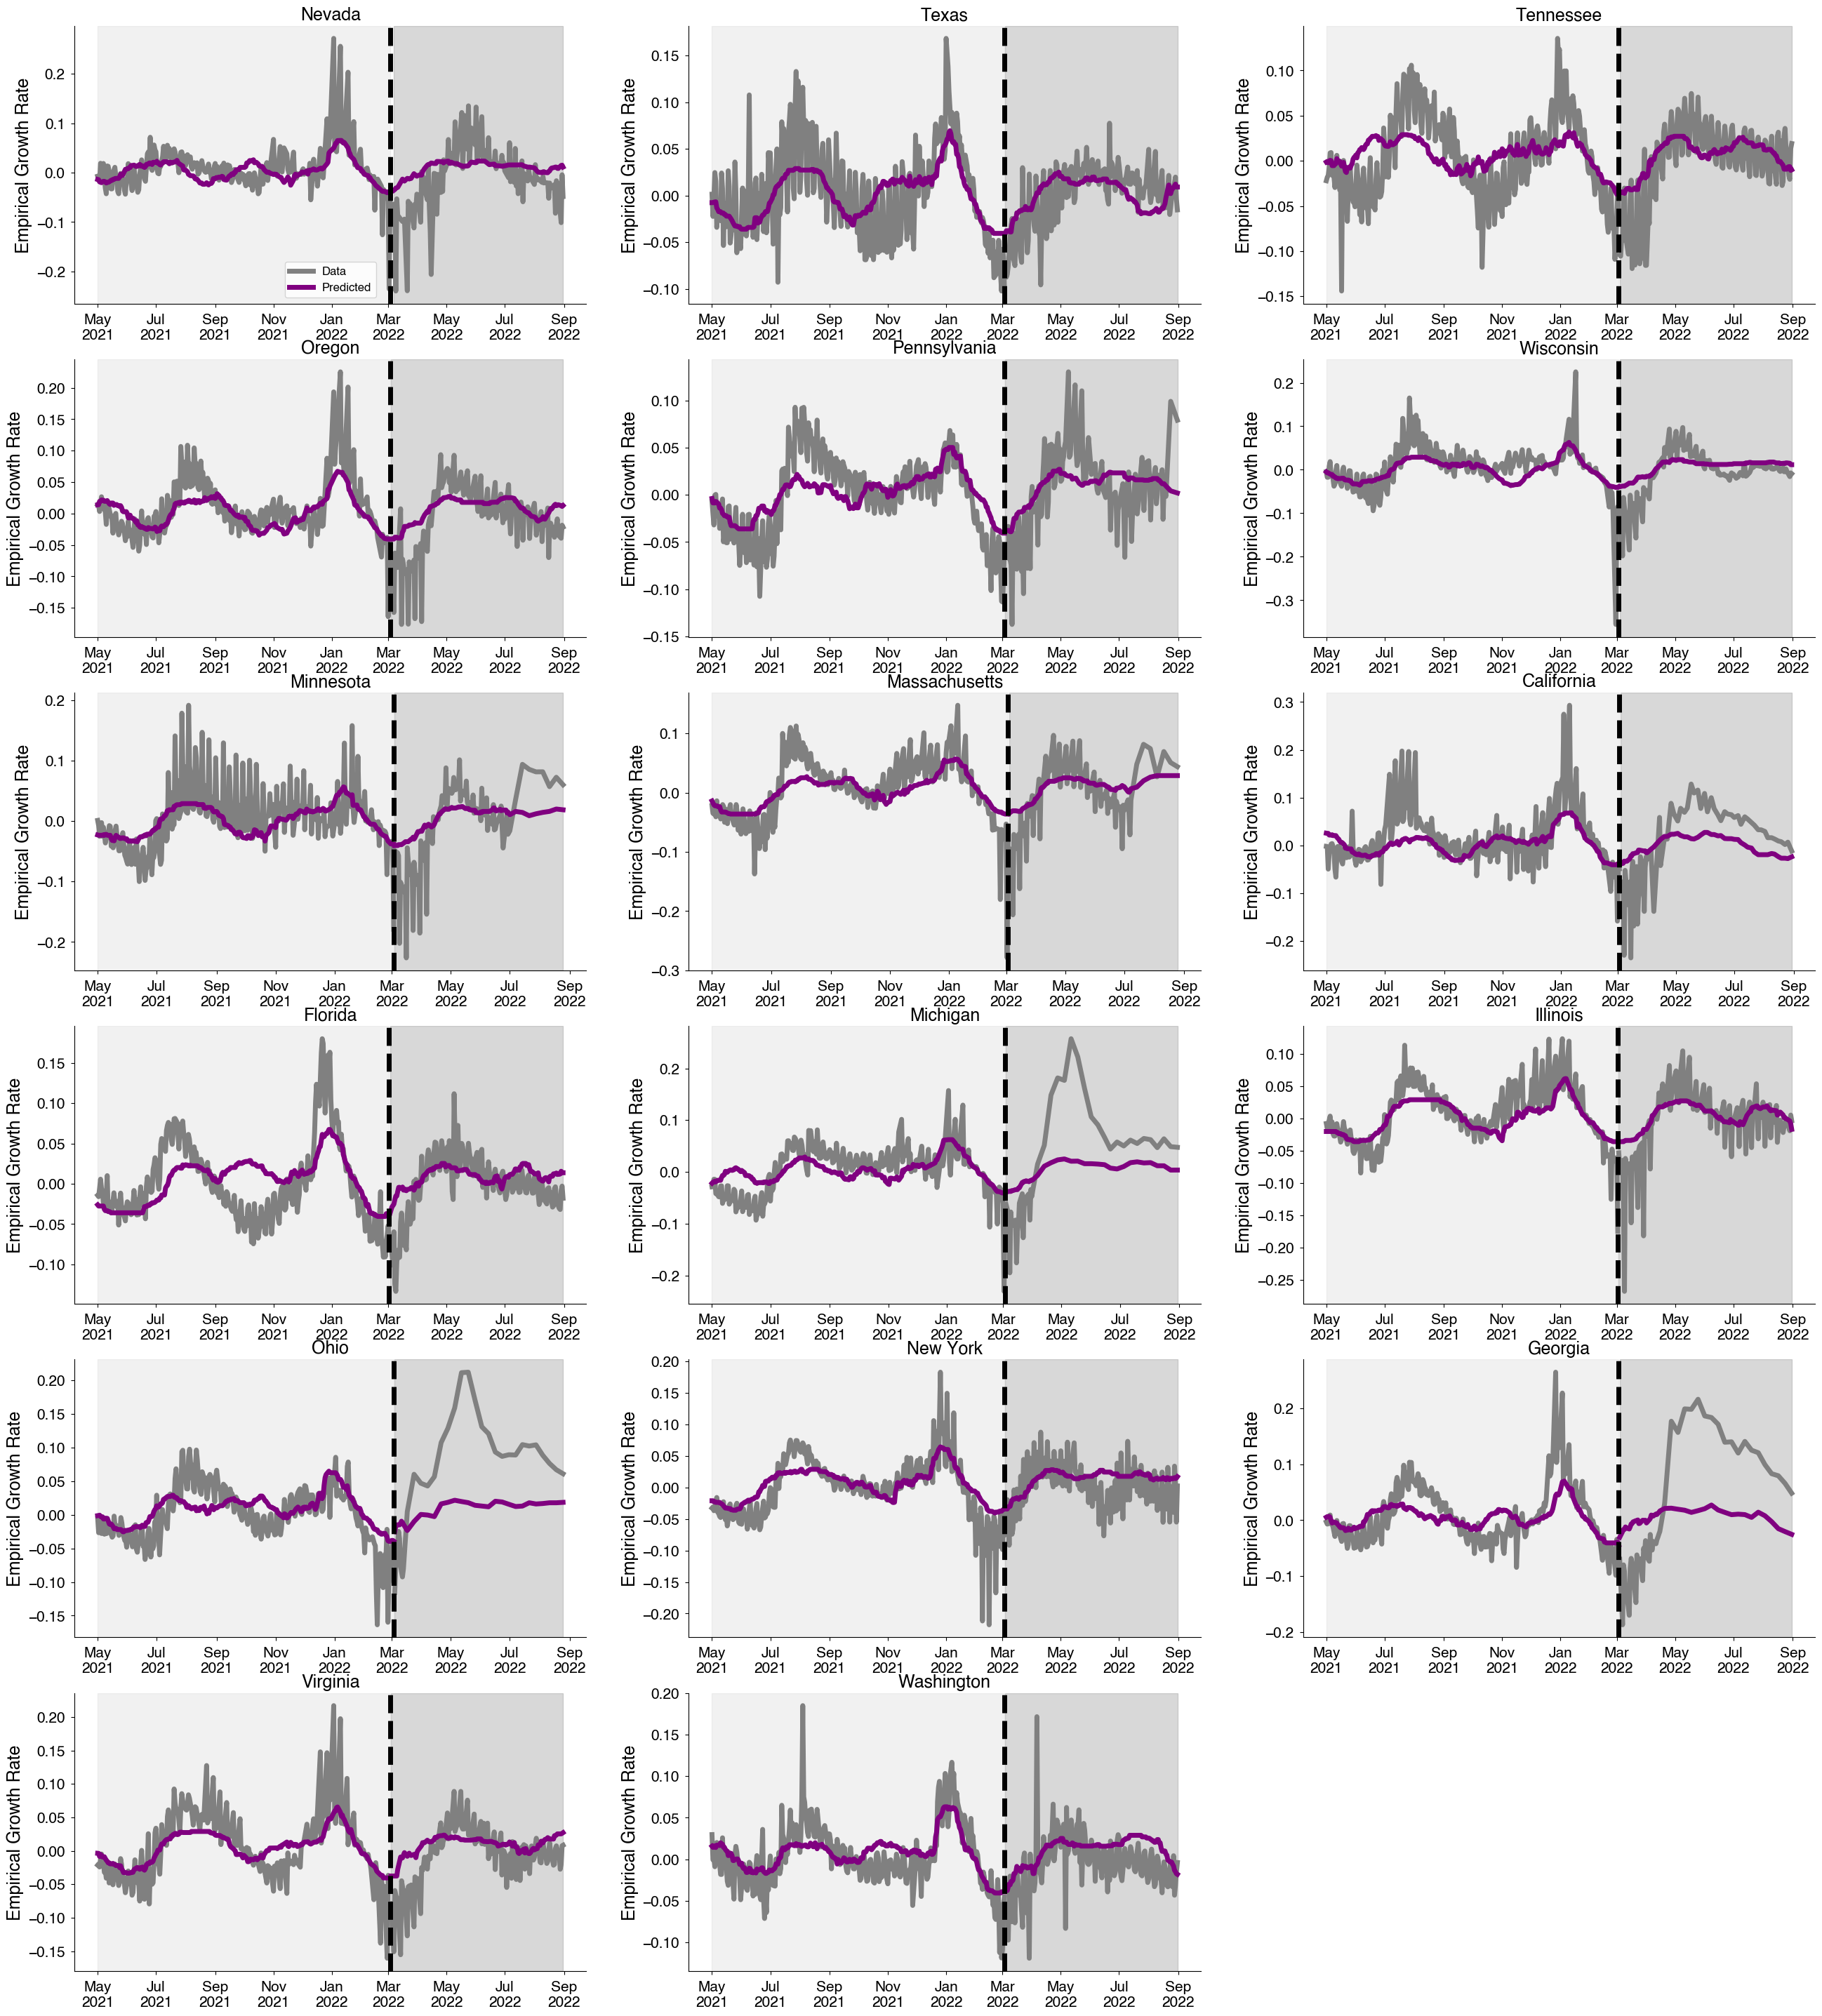

In [476]:
import matplotlib.dates as mdates
def plot_yeqx(ax):
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        return None
    
fig = plt.figure(figsize=(32, 36))
spec = fig.add_gridspec(ncols=3, nrows=len(locations) // 3 + 1)

for l, loc in enumerate(locations):
    ax = fig.add_subplot(spec[l])
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color="grey", label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color="grey")
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color="purple", label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color="purple")
    
    
    # Highlight test and training sets
    ax.axvline(dates_vec[X.index][loc_idx_train].max(), color="k", linestyle="--")
    ax.axvspan(dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max(), color="grey", alpha=0.3)
    ax.axvspan(dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max(), color="lightgrey", alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()

fig.savefig("figures/empirical-growth-rate-predictions.png")
#TODO: 
# 1. Validation on England predicting BQ.1 and BA.5
# 2. Split out on US + Global

# TODO:
# 1. Figure on cross-validation scheme

# TODO:
# Update to Latent Immunity model

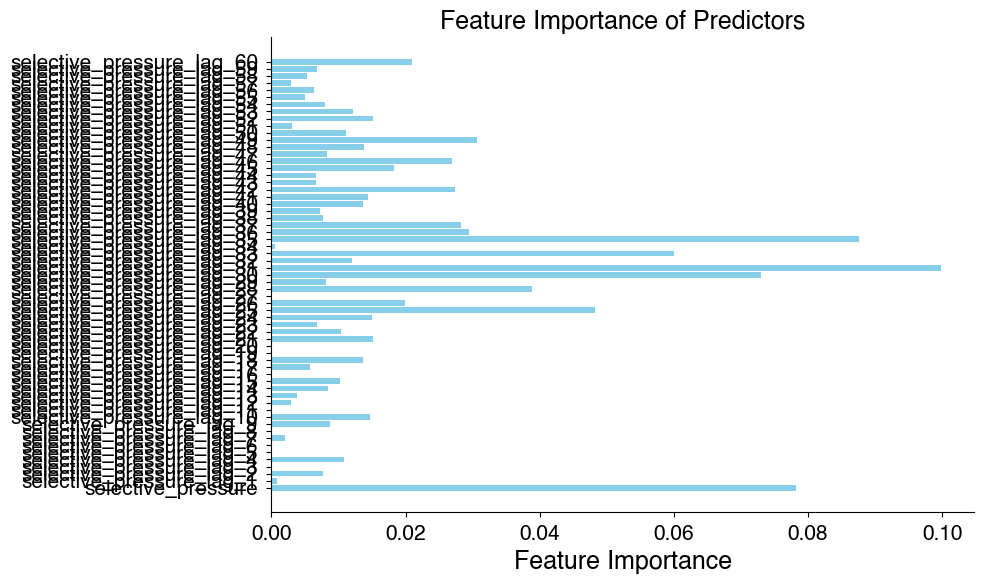

In [477]:
# Example feature importances and names
#feature_importances = model.coef_ # Replace with your model's feature importances
feature_importances = model.feature_importances_
feature_names = X.columns  # Replace with your actual feature names

# Create figure and gridspec
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 1)

# Create a subplot for feature importances
ax = fig.add_subplot(gs[0, 0])

# Plotting
indices = np.argsort(feature_importances)
indices = np.arange(feature_importances.shape[0])
ax.barh(range(len(indices)), feature_importances[indices], color='skyblue', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(np.array(feature_names)[indices])
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importance of Predictors')

plt.tight_layout()
plt.show()

In [ ]:
dates_vec